In [115]:
import os
import numpy as np
import tensorflow as tf
import keras
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras import layers
import sys,os
import numpy
from typing import List
sys.path.append(os.getcwd())

## Model

### Creating conv model (the simplest one)

In [144]:
num_classes = 10
input_shape = (28,28,1)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [181]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        # layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Flatten(name = 'flatten'),
        layers.Dropout(0.5, name = 'dropout'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

model.summary() #dodać kolejną konwolucję bez maxpoolingu

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
last_conv (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
maxpool (AveragePooling2D)   (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                92170 

### Learning

In [182]:
batch_size = 128
epochs = 14

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/14
422/422 [==============================] - 52s 123ms/step - loss: 0.1785 - accuracy: 0.9440 - val_loss: 0.2717 - val_accuracy: 0.9812
Epoch 2/14
422/422 [==============================] - 52s 123ms/step - loss: 0.0669 - accuracy: 0.9794 - val_loss: 0.0409 - val_accuracy: 0.9885
Epoch 3/14
422/422 [==============================] - 51s 121ms/step - loss: 0.0516 - accuracy: 0.9838 - val_loss: 0.0420 - val_accuracy: 0.9892
Epoch 4/14
422/422 [==============================] - 52s 123ms/step - loss: 0.0449 - accuracy: 0.9853 - val_loss: 0.0386 - val_accuracy: 0.9897
Epoch 5/14
422/422 [==============================] - 52s 123ms/step - loss: 0.0388 - accuracy: 0.9872 - val_loss: 0.0481 - val_accuracy: 0.9868
Epoch 6/14
422/422 [==============================] - 52s 122ms/step - loss: 0.0343 - accuracy: 0.9885 - val_loss: 0.0364 - val_accuracy: 0.9907
Epoch 7/14
422/422 [==============================] - 51s 122ms/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 0.0352 - val_ac

In [184]:
#teraz average pooling
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.036512237042188644
Test accuracy: 0.9901000261306763


In [179]:
#without maxpool with second conv
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03927687183022499
Test accuracy: 0.9911999702453613


In [175]:
#without maxpool
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.049009766429662704
Test accuracy: 0.9882000088691711


In [172]:
#with batchnormalization
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02522582747042179
Test accuracy: 0.9922999739646912


In [147]:
#original
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02599981427192688
Test accuracy: 0.991599977016449


In [148]:
model.save("basic_model.keras")

In [149]:
model2 = keras.models.load_model("basic_model.keras")

In [150]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
last_conv (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
maxpool (MaxPooling2D)       (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16010 

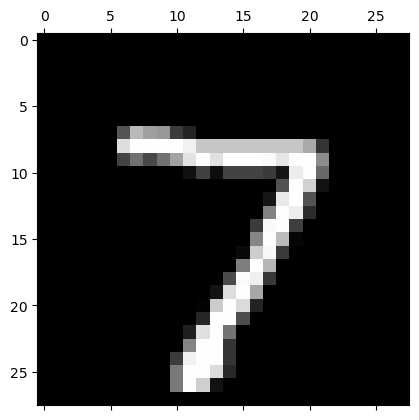

In [151]:
plt.matshow(x_test[0], cmap='gray')
plt.show()

In [152]:
data = model.predict(x_test)

In [153]:
np.argmax(data[0])

7

## CAM XAI Technic

In [167]:
class heatmap_creator():
    """Grad-CAM heatmapy creator class
    """    
    
    
    def __init__(self, model: keras.Sequential, last_conv_layer_name: str, classifier_layer_names: List[str] = ['max_pooling2d_1', 'flatten', 'dropout', 'dense', 'softmax']):
        """Initial class

        Args:
            model (keras.Sequential): The Mnist Classificator
            last_conv_layer_name (str): The name of the last convolutional layer
            classifier_layer_names (List[str], optional): The names of the layers after the last convolutiona layer. Defaults to ['max_pooling2d_1', 'flatten', 'dropout', 'dense', 'softmax'].
        """        
        last_conv_layer = model.get_layer((last_conv_layer_name))
        self.last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
        
        classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
        x = classifier_input
        for layer_name in classifier_layer_names:
            x = model.get_layer(layer_name)(x)
        self.classifier_model = keras.Model(classifier_input, x)
    
    def preparing_image(self, img: numpy.ndarray):

        if type(img) != numpy.ndarray:
            try:
                img = keras.preprocessing.image.img_to_array(img)
            except:
                print("The input should be numpy.ndarray")
        img = np.expand_dims(img, axis = 0)
        
        return img
    
    def create_heatmap(self, img):
        with tf.GradientTape() as tape:
            last_conv_layer_output = self.last_conv_layer_model(img)
            tape.watch(last_conv_layer_output)
            
            
            preds = self.classifier_model(last_conv_layer_output)
            top_pred_index = tf.argmax(preds[0])
            top_class_channel = preds[:, top_pred_index]
            
        grads = tape.gradient(top_class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis = (0,1,2))
        
        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:,:,i] *= pooled_grads[i]
            
        heatmap = np.mean(last_conv_layer_output, axis = -1)
        heatmap = np.maximum(heatmap, 0)/np.max(heatmap)
        
        plt.matshow(heatmap)
        return heatmap
    
    def create_visualization(self, img, alpha = 0.5):
        
        img = self.preparing_image(img)
        heatmap = self.create_heatmap(img)
        img = np.squeeze(img, axis = 0)
        
        heatmap = np.uint8(255 * heatmap)
        img = np.uint8(255 * img)
        jet = mpl.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
        
        sup_img = jet_heatmap * alpha + img
        sup_img = keras.preprocessing.image.array_to_img(sup_img)
        
        # display(sup_img, )
        plt.matshow(sup_img)
        plt.matshow(img, cmap = 'binary')
        plt.show()
    

In [165]:
def get_img_array(img_path):
    array = keras.preprocessing.image.img_to_array(img_path)
    array = np.expand_dims(array, axis = 0)
    return array

def make_grad_heatmap2(img, model, last_conv_layer_name, classifier_layer_names = ['max_pooling2d_1', 'flatten', 'dropout', 'dense', 'softmax']):
    '''
    '''
    #mapping input to the last activation layer
    last_conv_layer = model.get_layer((last_conv_layer_name))
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img)
        tape.watch(last_conv_layer_output)
        
        
        #creating outputs
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
     
    #pierwsze równanie z paperu    
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis = (0,1,2))
    
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:,:,i] *= pooled_grads[i]
        
    heatmap = np.mean(last_conv_layer_output, axis = -1)
    heatmap = np.maximum(heatmap, 0)/np.max(heatmap)
    
    plt.matshow(heatmap)
    return heatmap

def save(img, heatmap, cam_path = 'cam.jpg', alpha = 0.6):
    
    #Load the image (now, without loading)
    
    img = keras.preprocessing.image.img_to_array(img)
    
    
    
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    sup_img = jet_heatmap * alpha + img
    sup_img = keras.preprocessing.image.array_to_img(sup_img)
    
    # display(sup_img, )
    plt.matshow(sup_img)
    plt.matshow(jet_heatmap )
    plt.matshow(img, cmap = 'binary')


## Testing the XAI

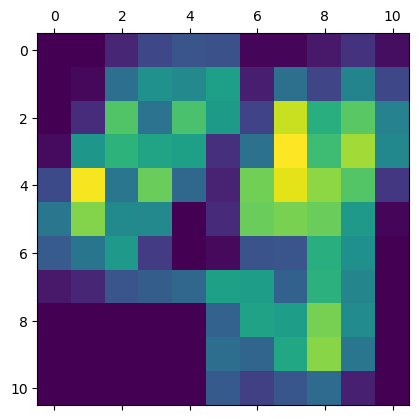

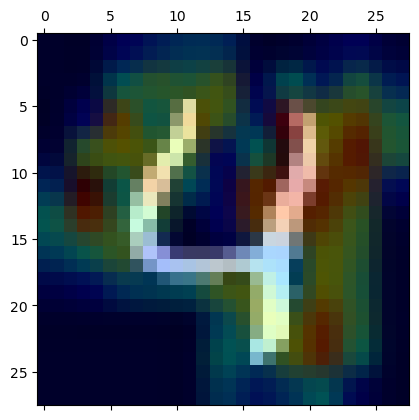

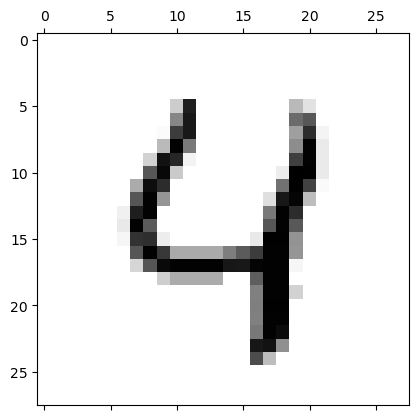

In [168]:
heat = heatmap_creator(model2, 'last_conv', ['maxpool', 'flatten', 'dropout', 'dense', 'softmax'])
heatmap = heat.create_visualization(x_test[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


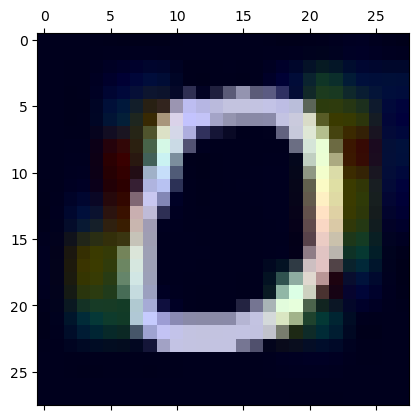

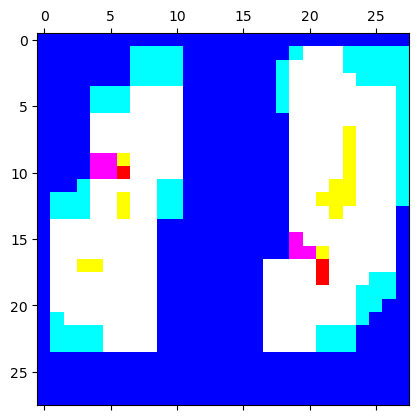

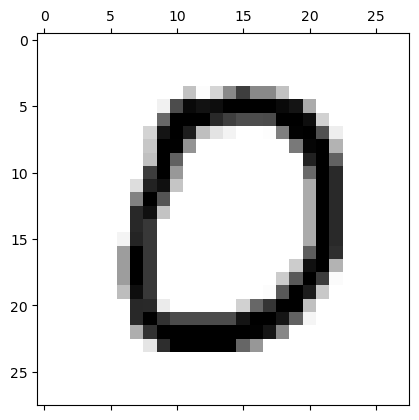

In [ ]:
heatmap = heat.create_visualization(x_test[10])

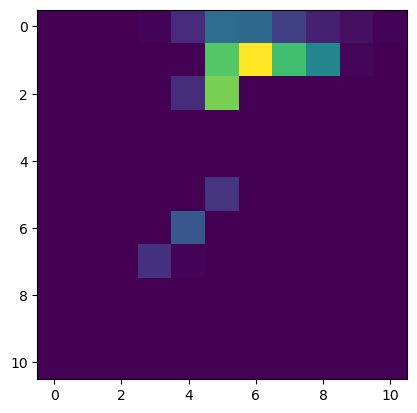

In [129]:
img_array = get_img_array(x_test[12])
heatmap = make_grad_heatmap2(img_array, model2, 'conv2d_1')
plt.imshow(heatmap)
plt.imsave('heatmap.jpg', heatmap)


In [132]:
img  = get_img_array(x_test[12])
save(img, heatmap)


ValueError: Unsupported image shape: (1, 28, 28, 1)

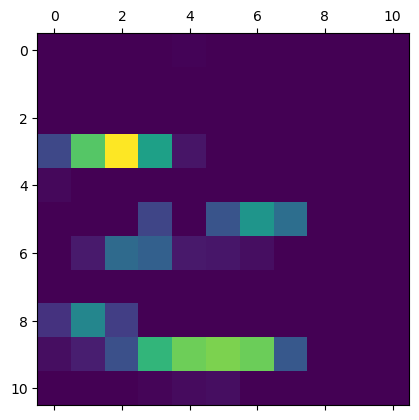

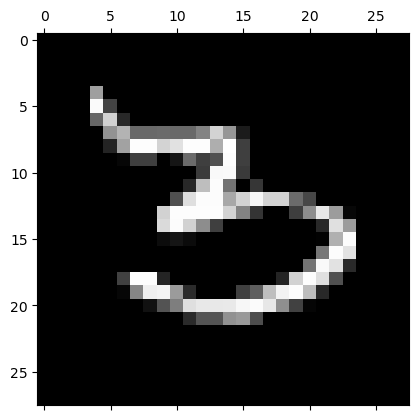

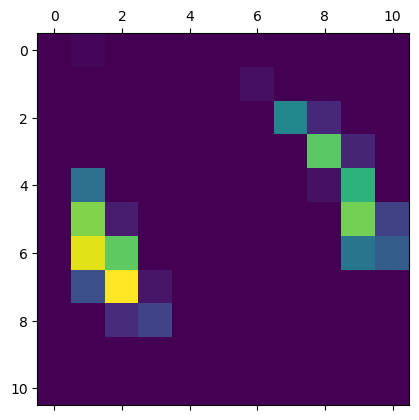

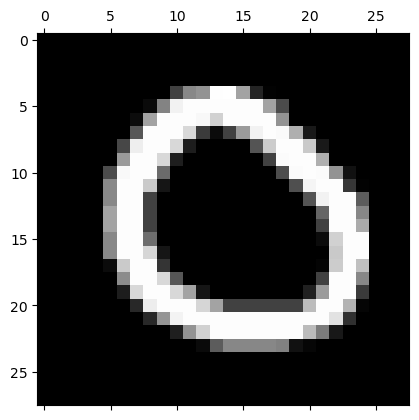

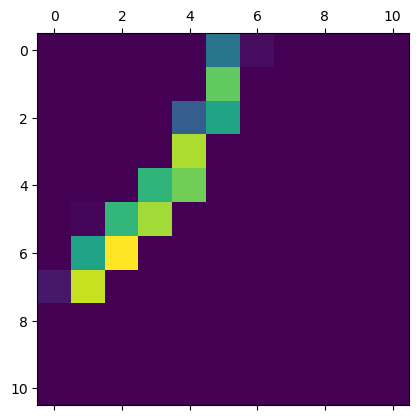

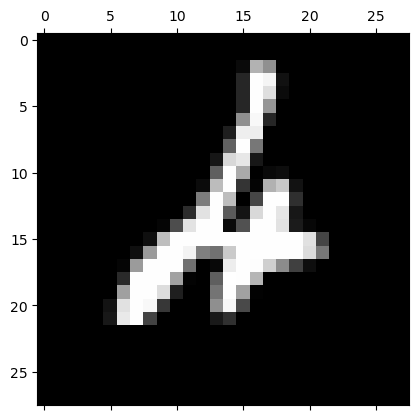

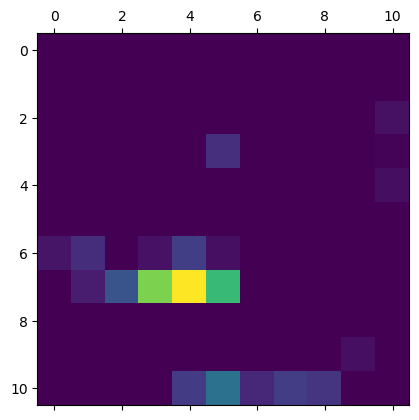

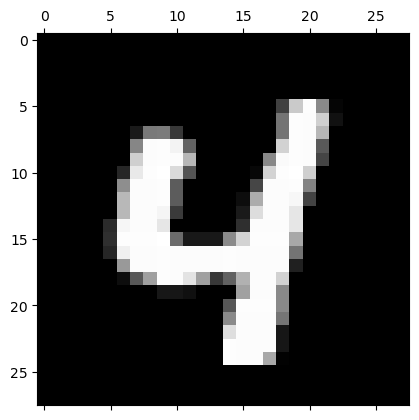

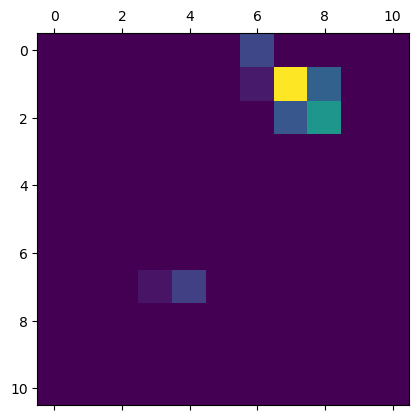

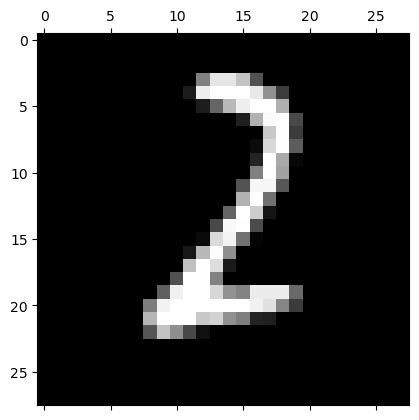

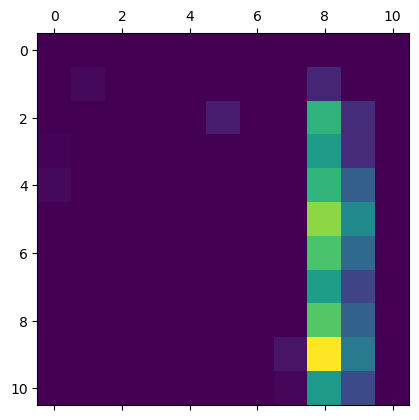

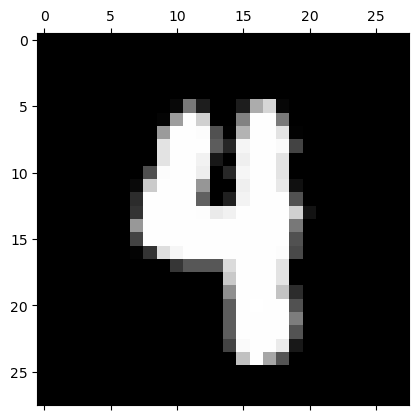

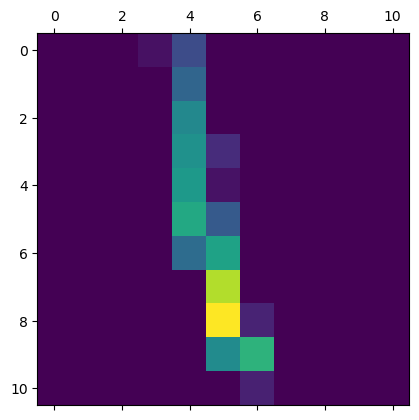

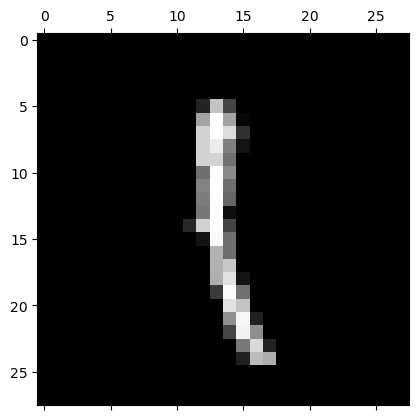

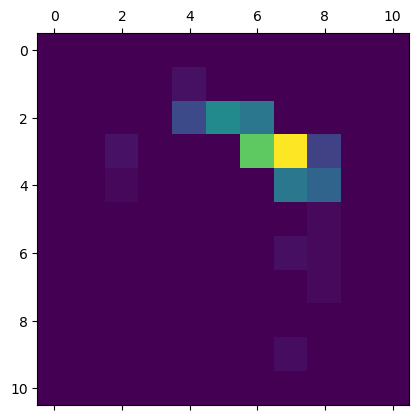

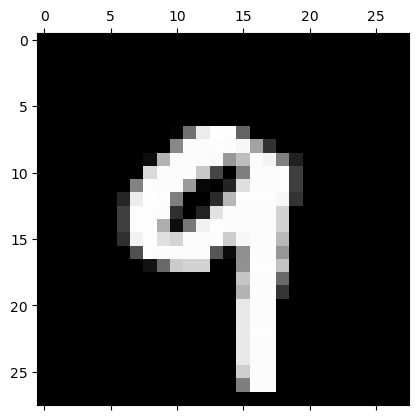

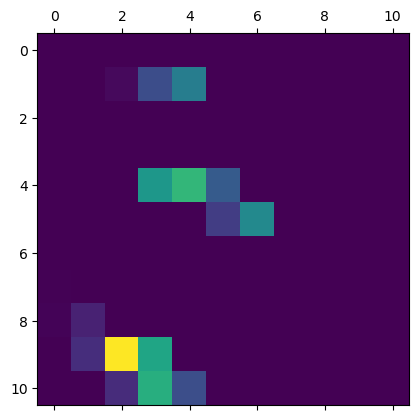

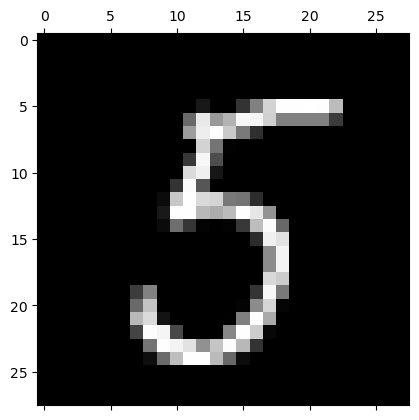

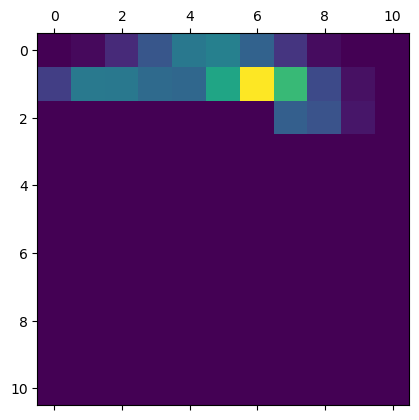

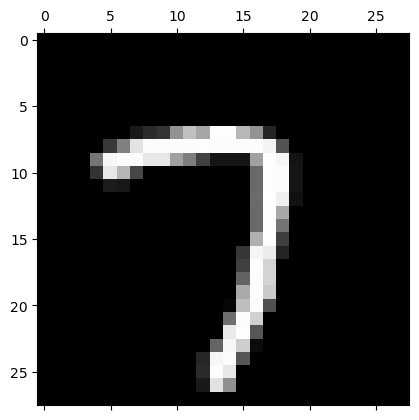

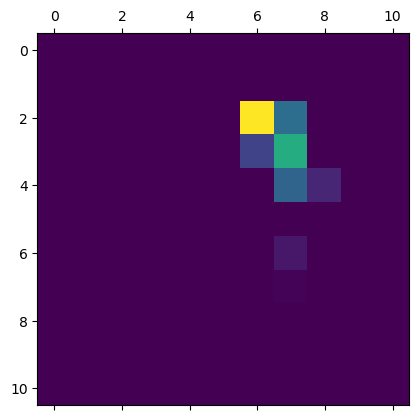

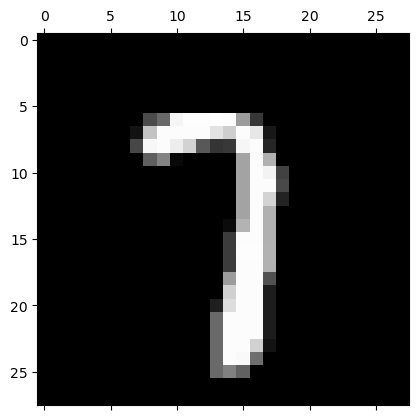

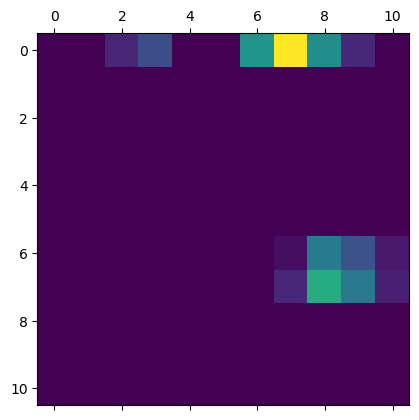

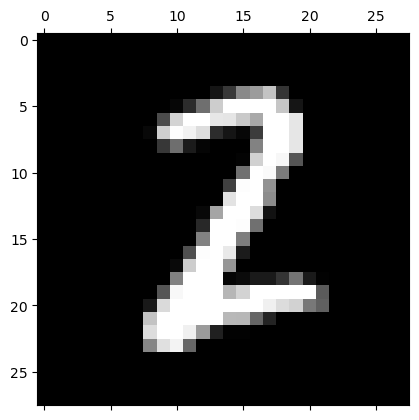

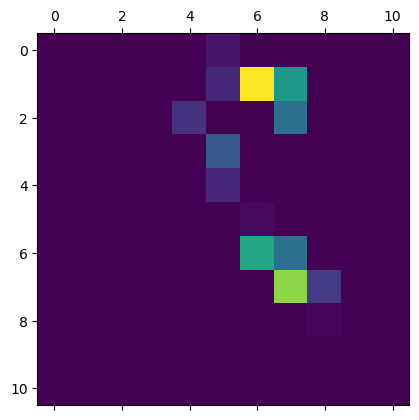

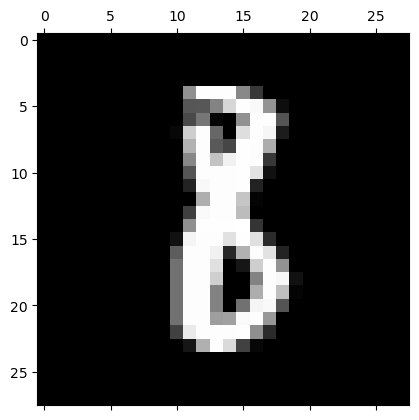

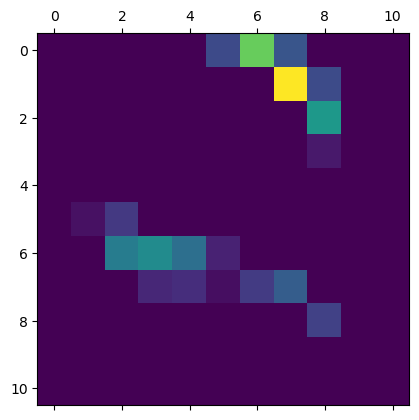

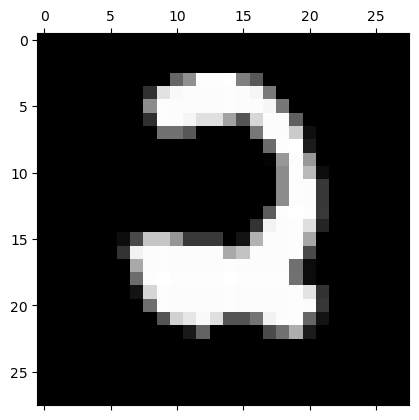

In [60]:
for i in range(245, 259):
    n = i
    img_array = get_img_array(x_test[n])
    heatmap = make_grad_heatmap2(img_array, model, 'conv2d_1')
    plt.matshow(heatmap)
    plt.matshow(x_test[n], cmap = 'gray')
    plt.show()

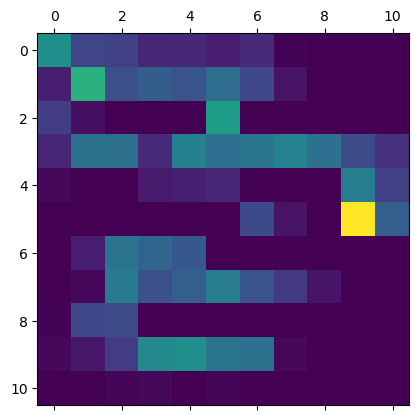

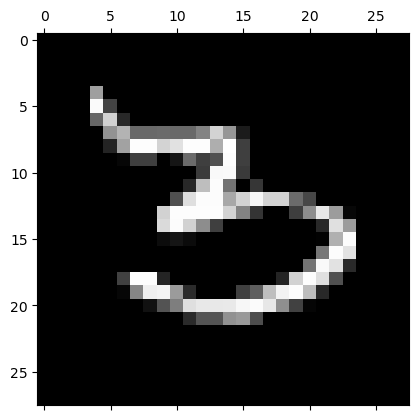

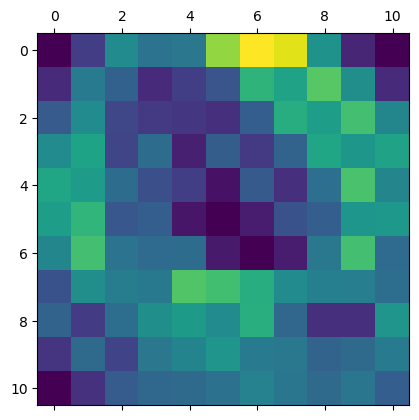

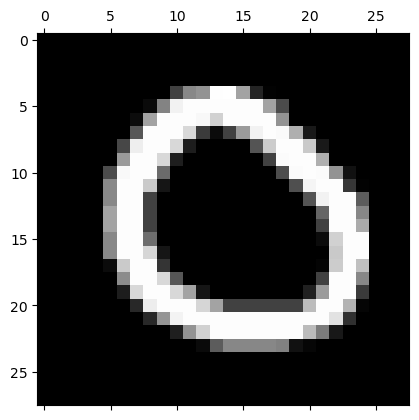

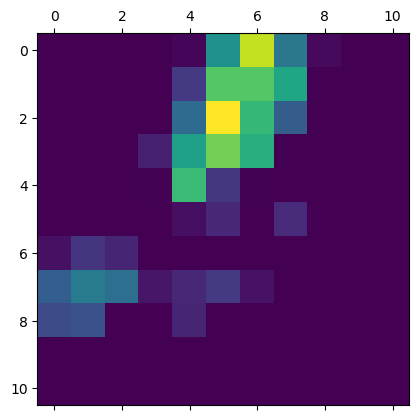

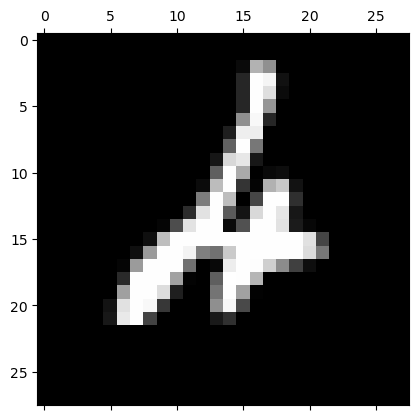

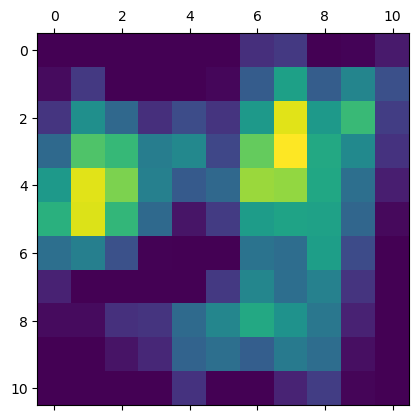

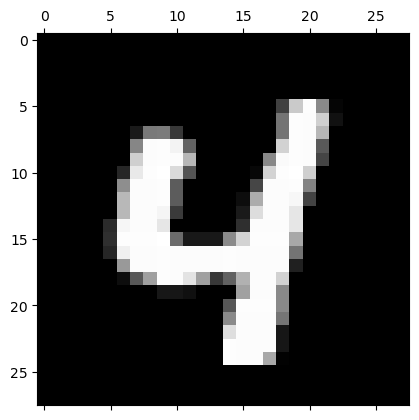

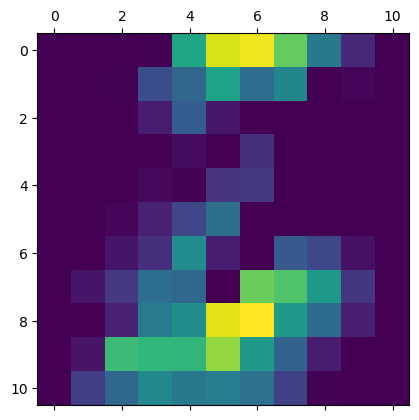

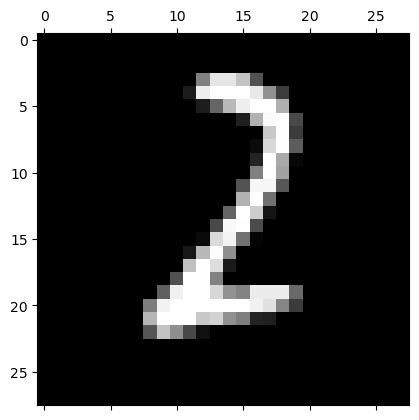

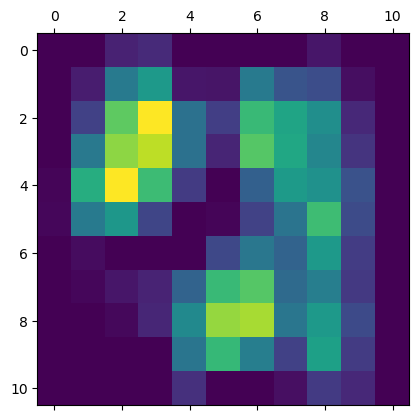

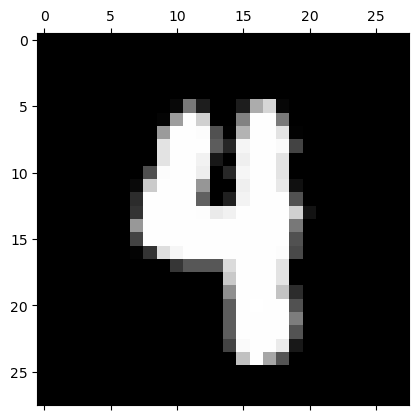

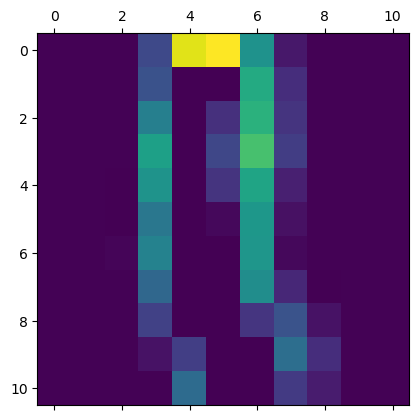

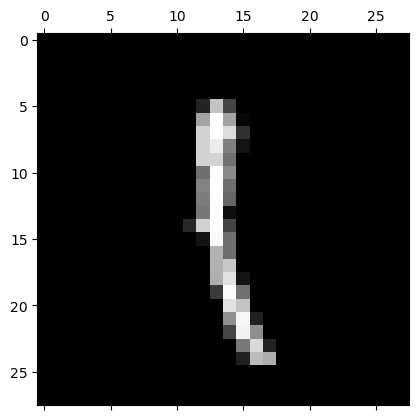

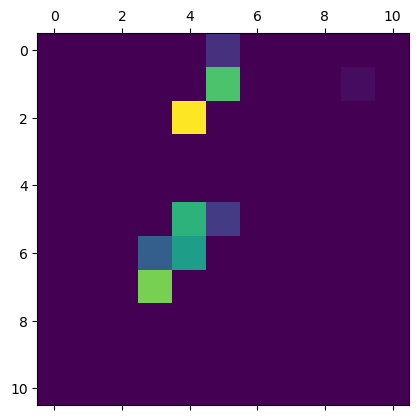

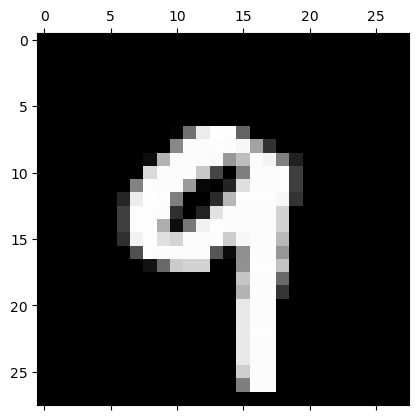

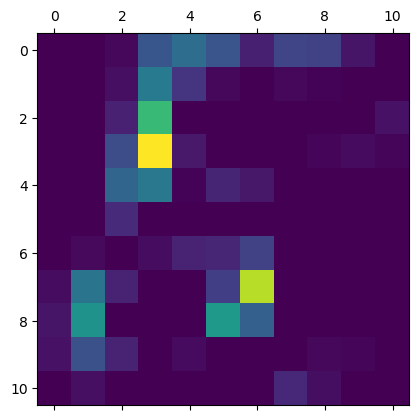

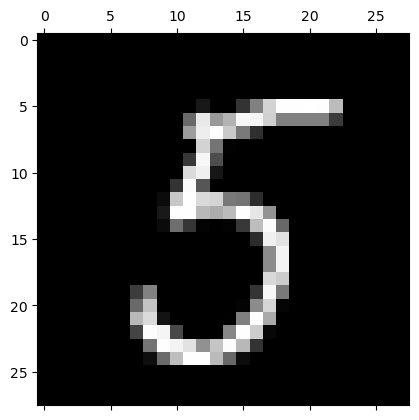

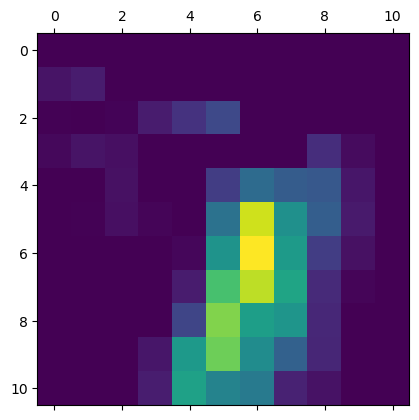

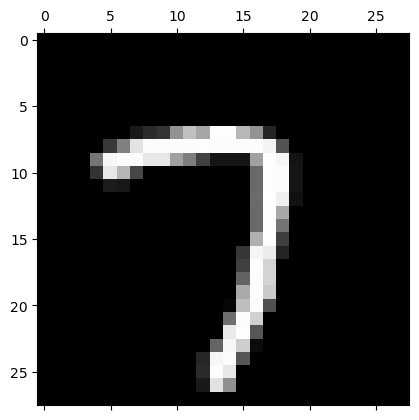

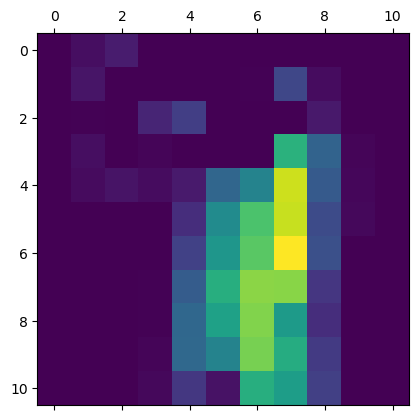

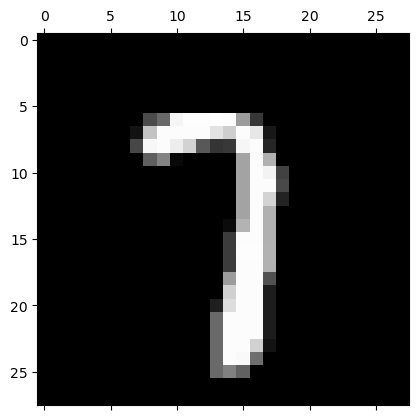

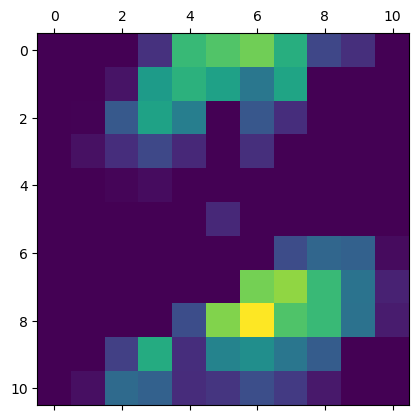

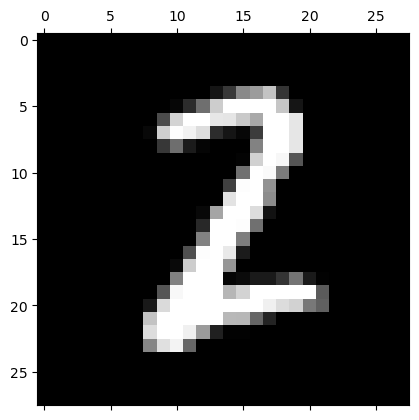

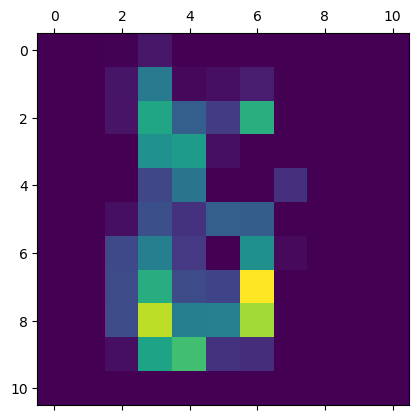

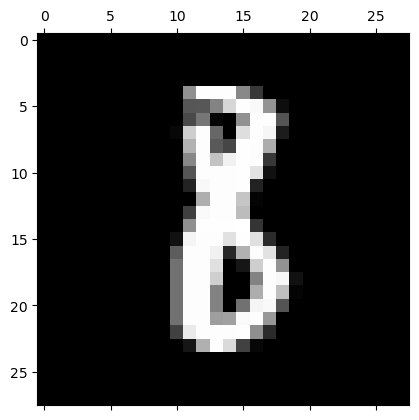

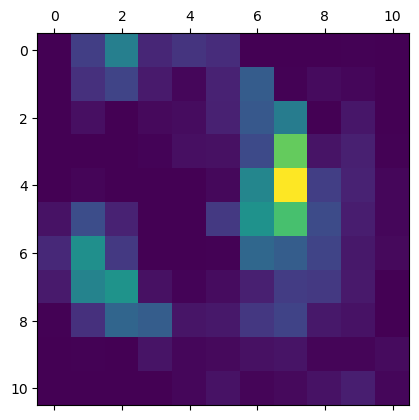

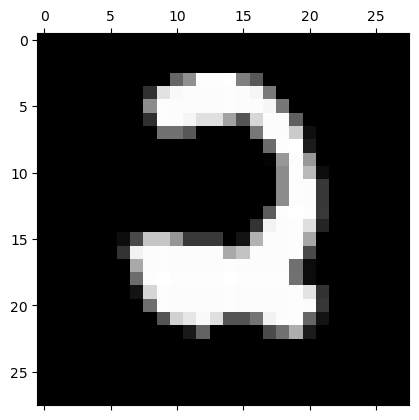

In [ ]:
for i in range(245, 259):
    n = i
    img_array = get_img_array(x_test[n])
    heatmap = make_grad_heatmap2(img_array, model, 'conv2d_1')
    plt.matshow(heatmap)
    plt.matshow(x_test[n], cmap = 'gray')
    plt.show()

In [133]:
xbar = x_test[1]

In [134]:
xbar = np.expand_dims(xbar, axis=0)

In [135]:
xbar.shape

(1, 28, 28, 1)

In [136]:
xbar = np.squeeze(xbar, axis=0)

In [138]:
xbar.shape

(28, 28, 1)

In [ ]:
##

## Testing different models

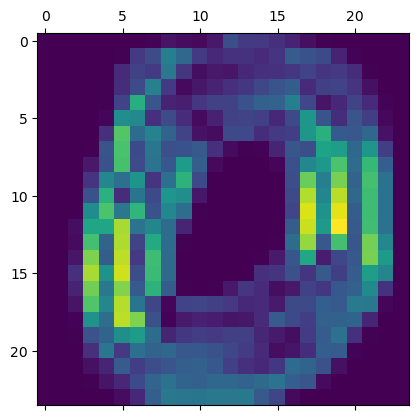

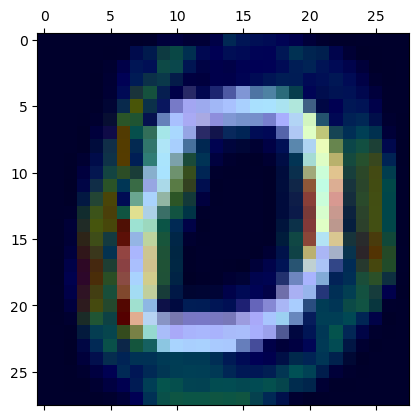

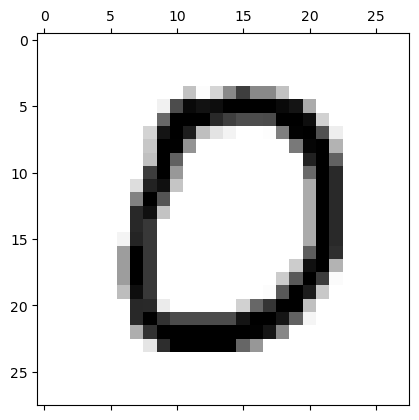

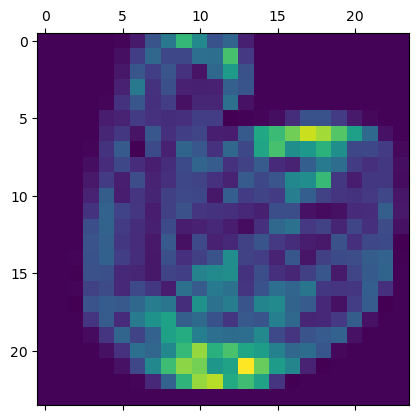

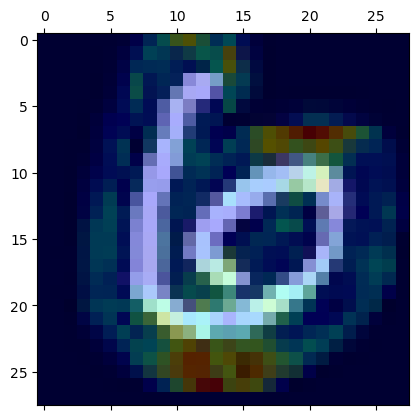

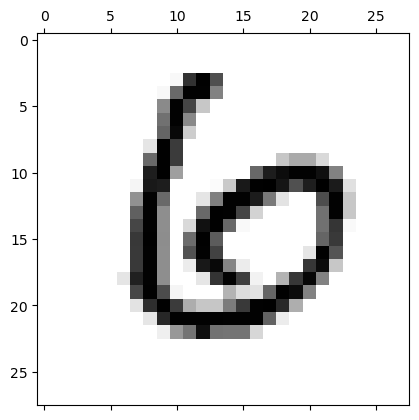

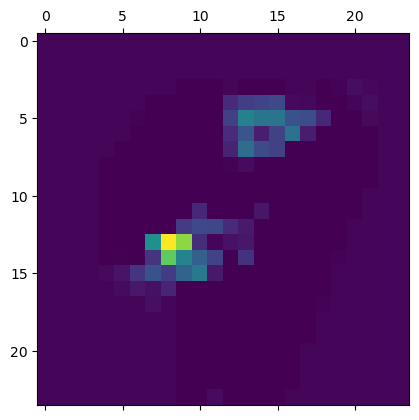

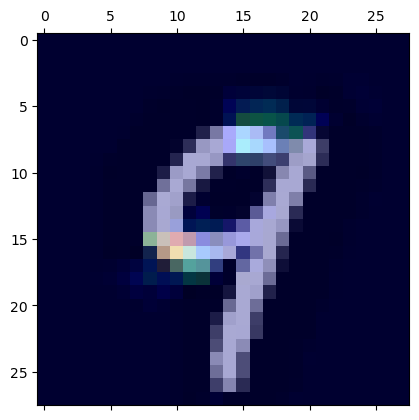

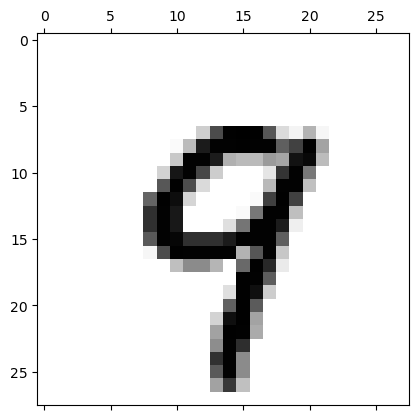

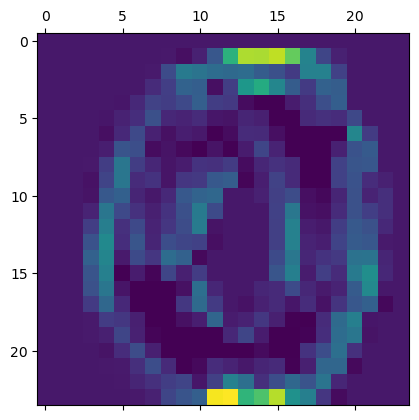

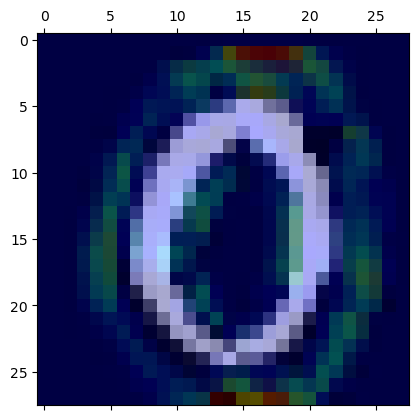

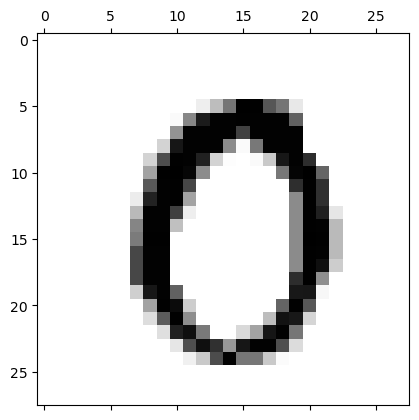

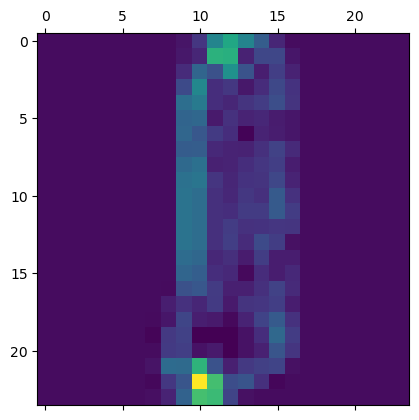

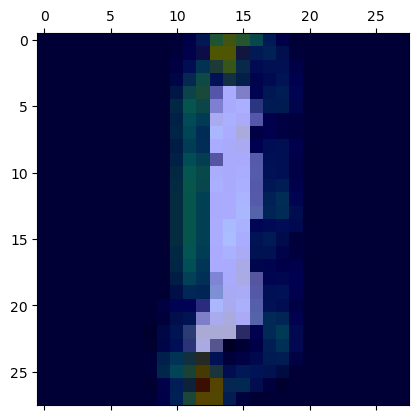

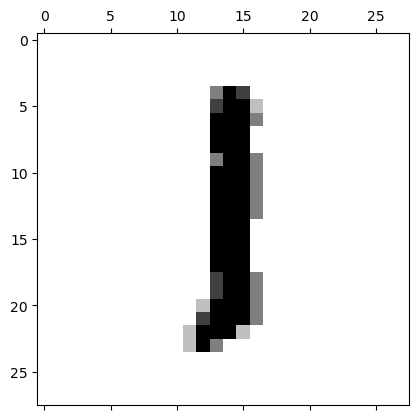

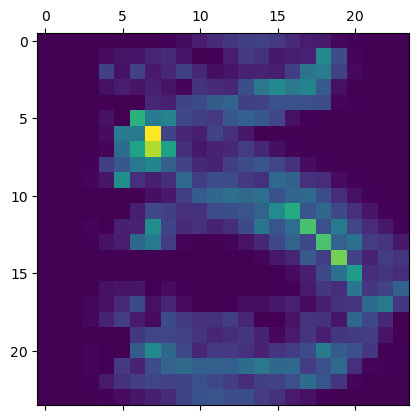

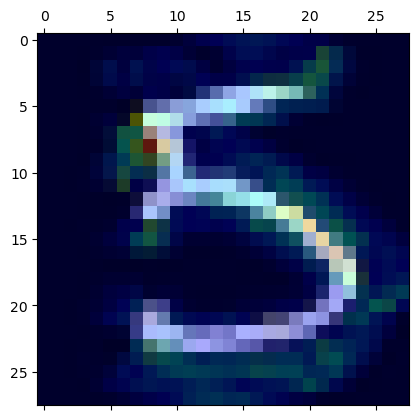

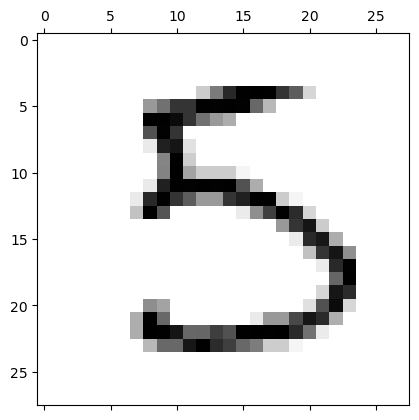

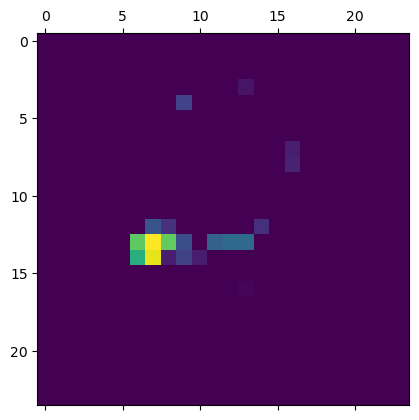

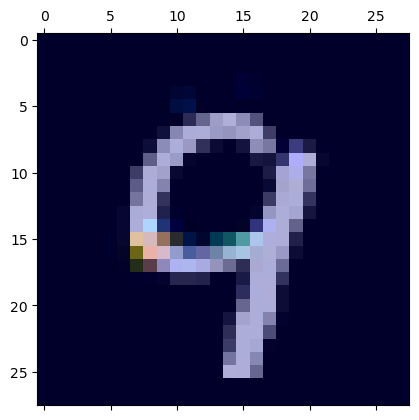

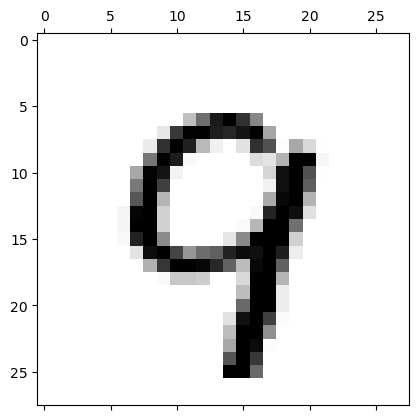

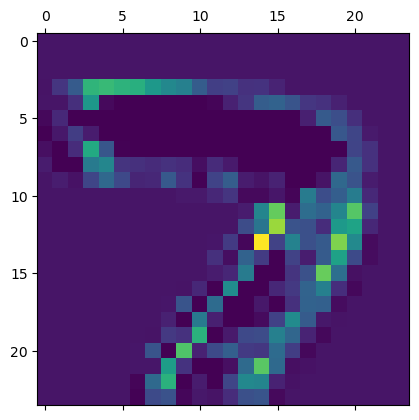

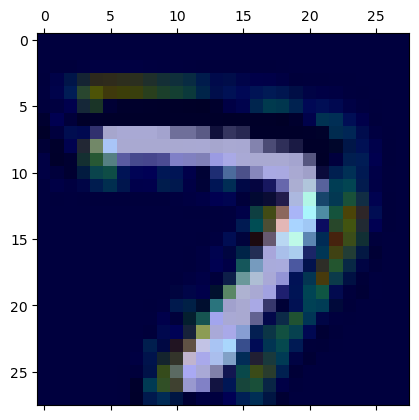

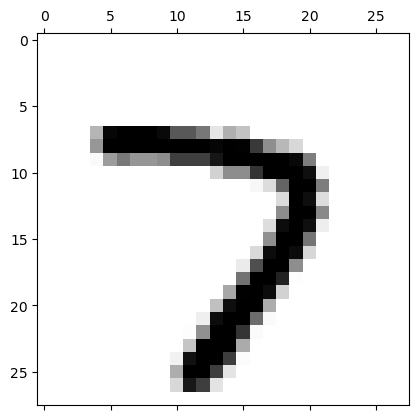

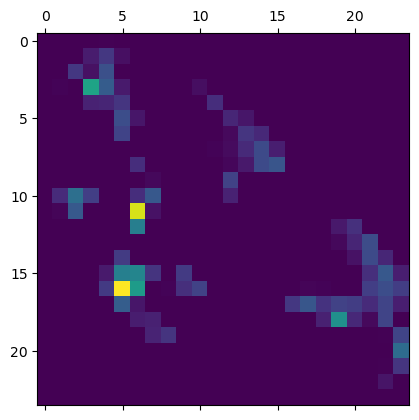

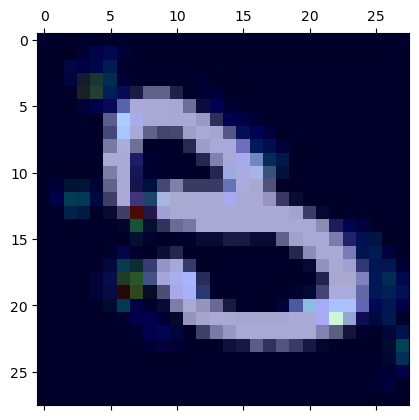

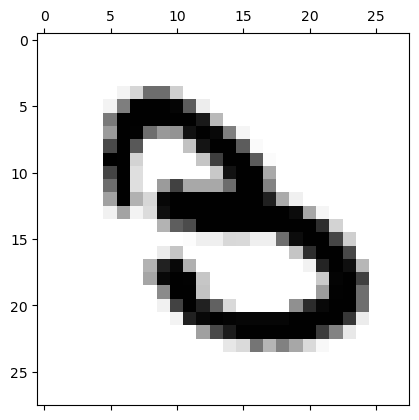

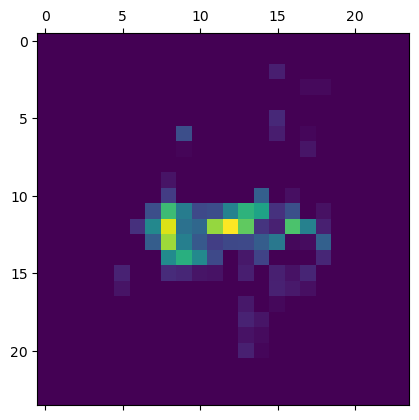

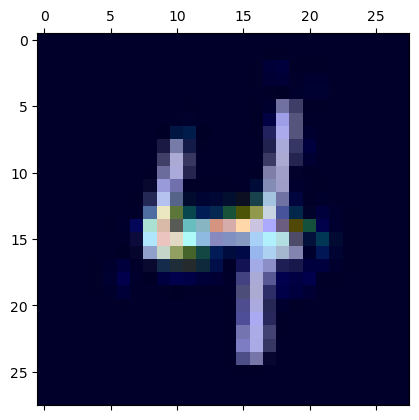

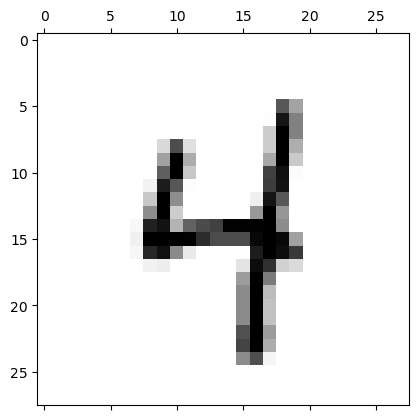

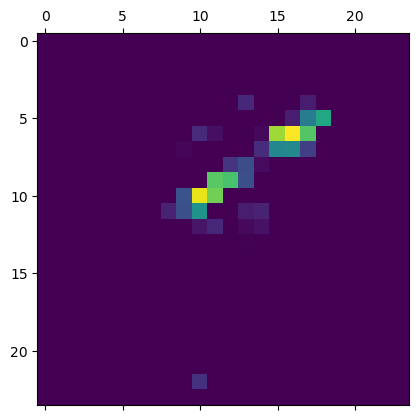

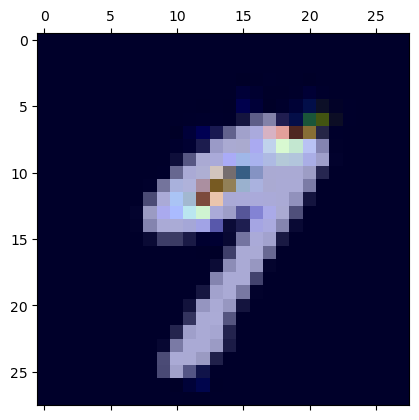

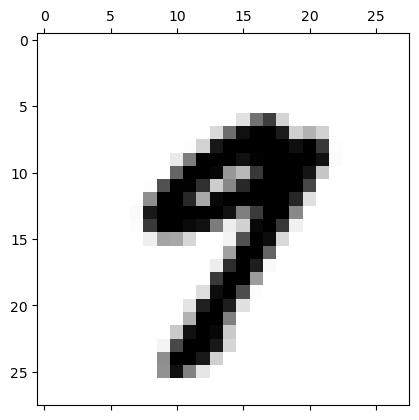

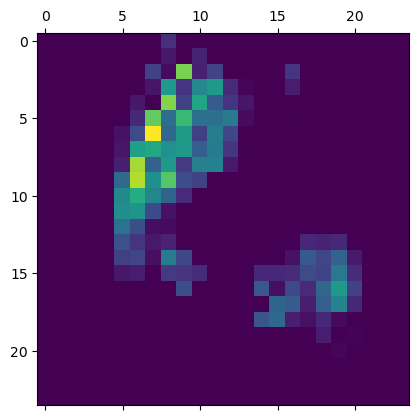

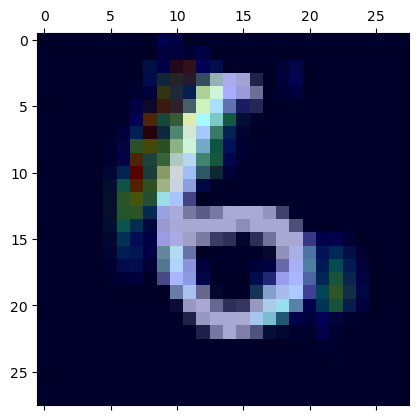

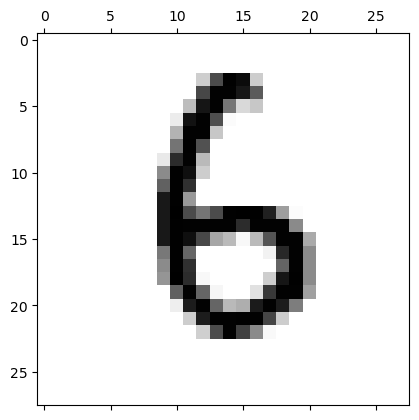

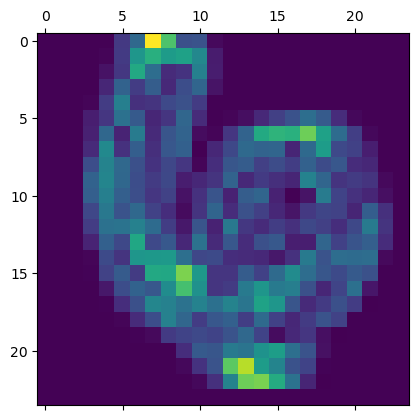

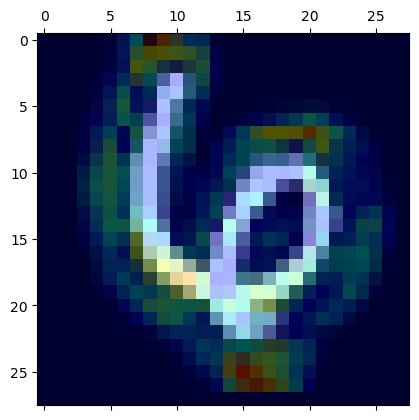

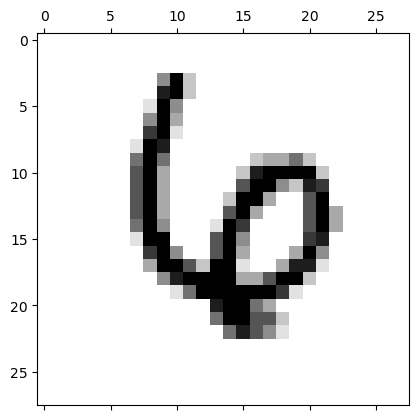

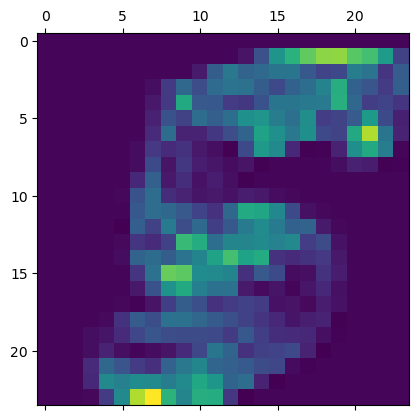

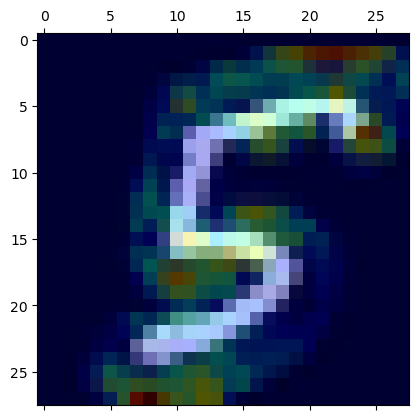

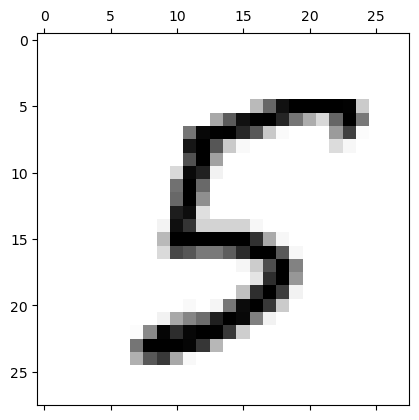

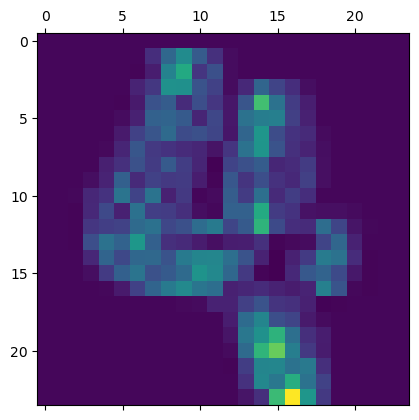

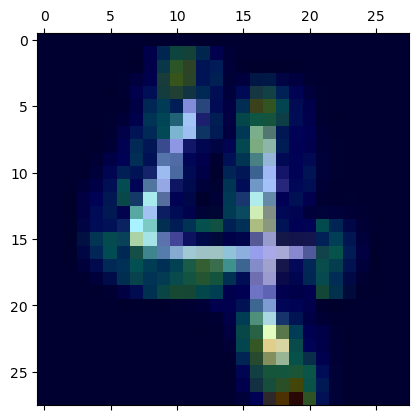

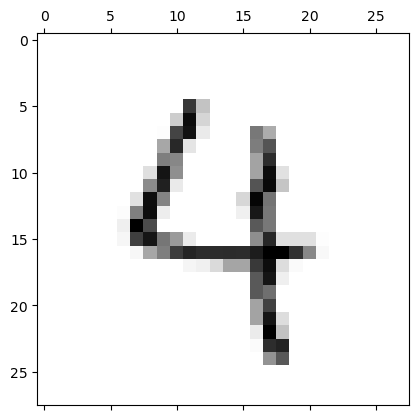

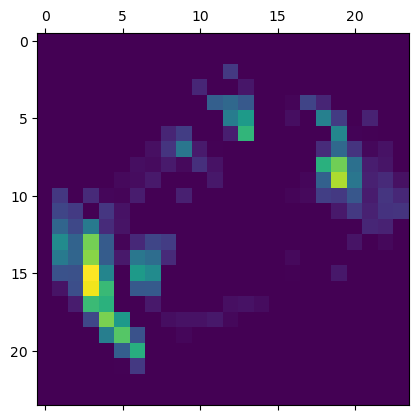

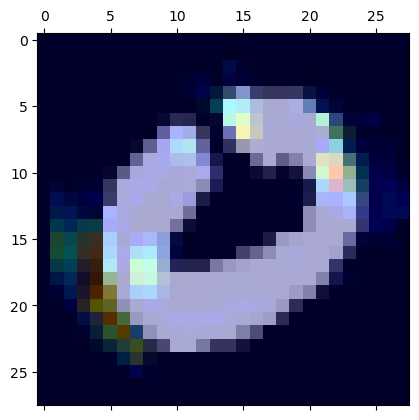

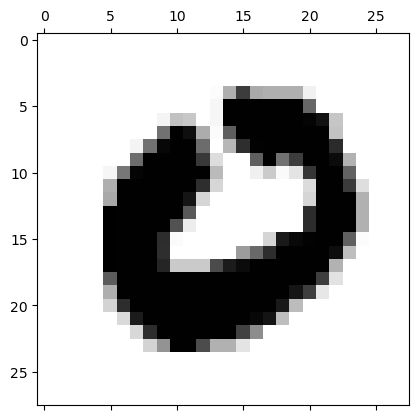

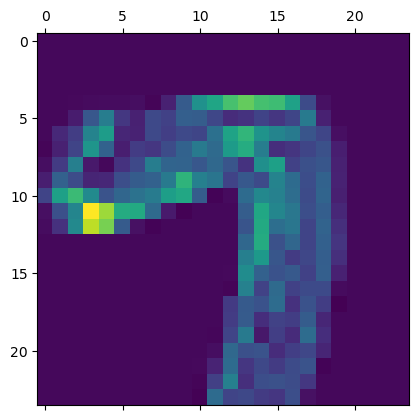

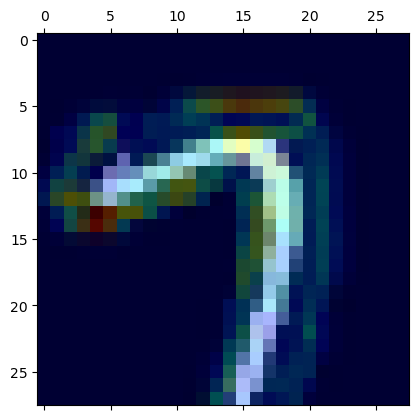

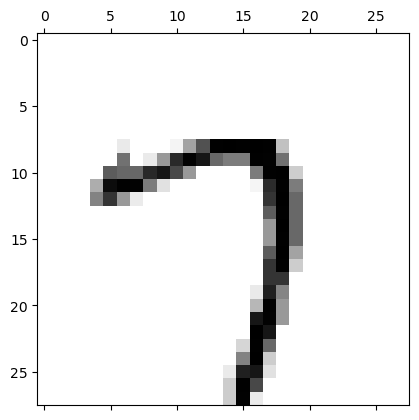

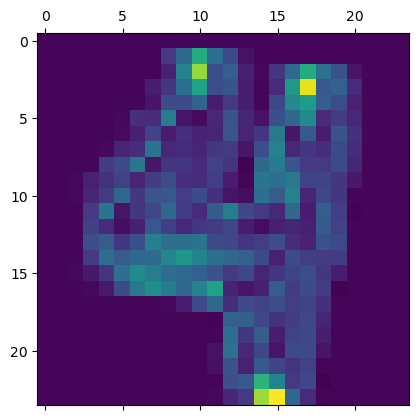

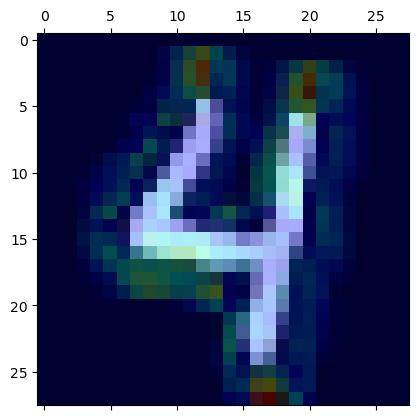

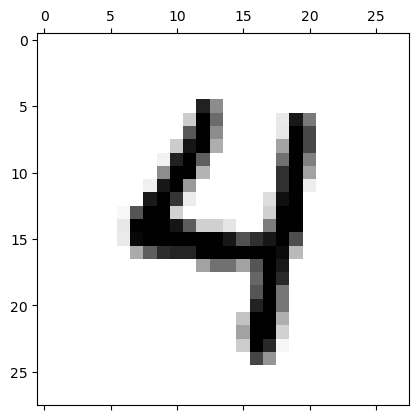

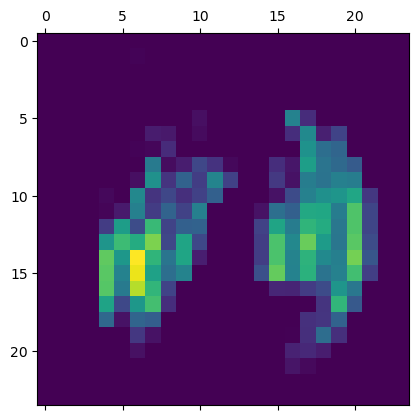

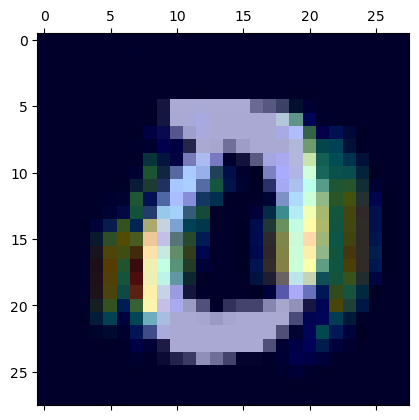

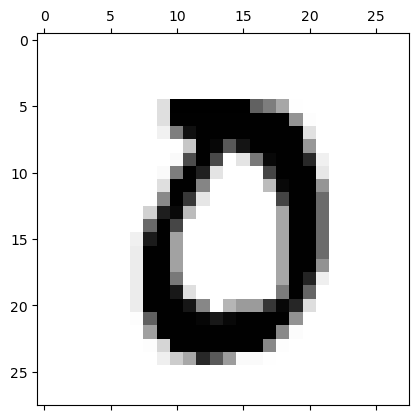

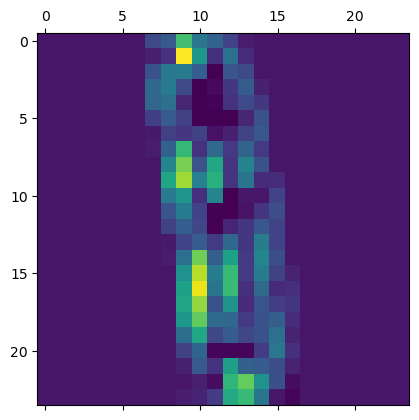

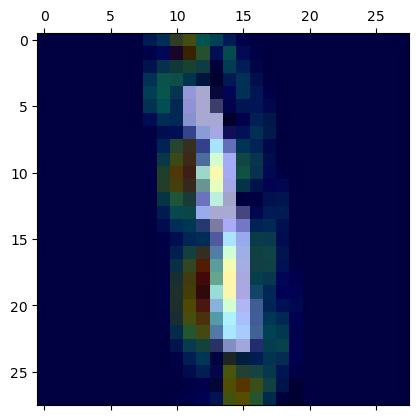

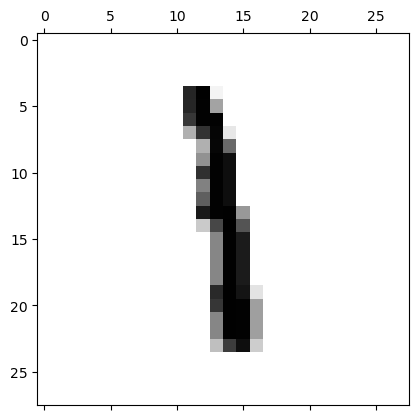

In [176]:
#without maxpooling 
for i in range(10,30):
    heat = heatmap_creator(model, 'last_conv', ['maxpool', 'flatten', 'dropout', 'dense', 'softmax'])
    heatmap = heat.create_visualization(x_test[i])

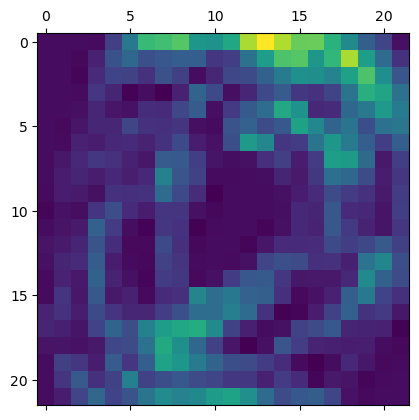

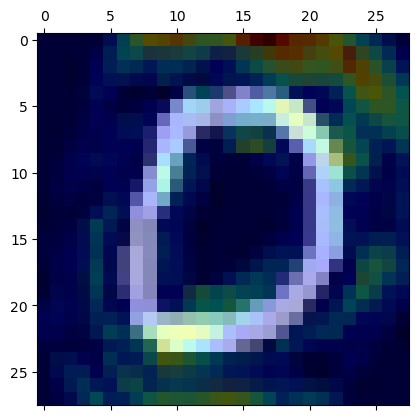

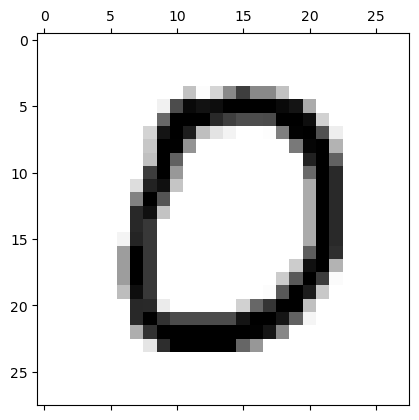

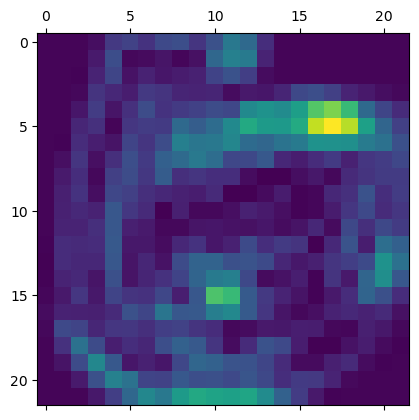

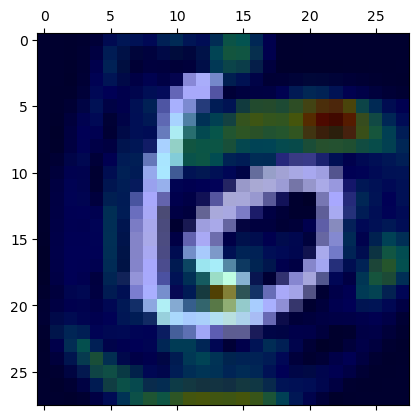

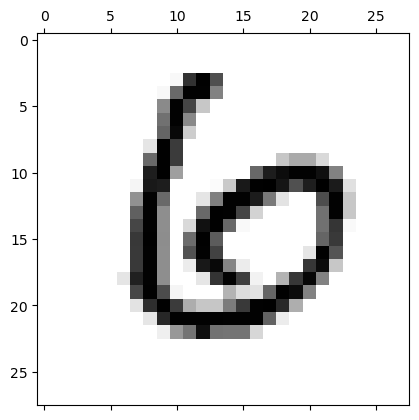

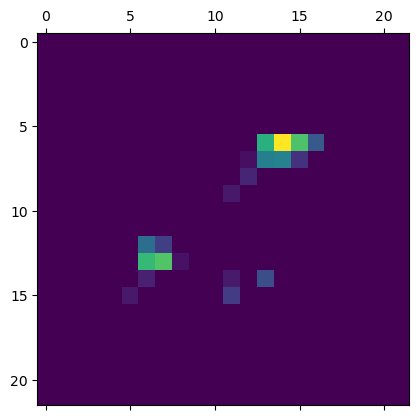

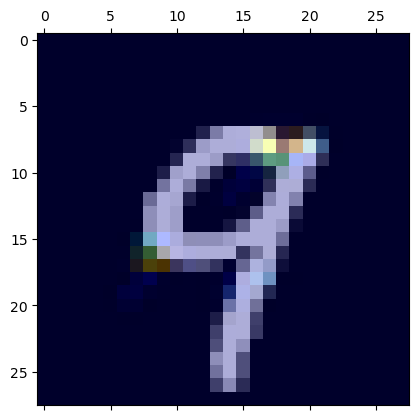

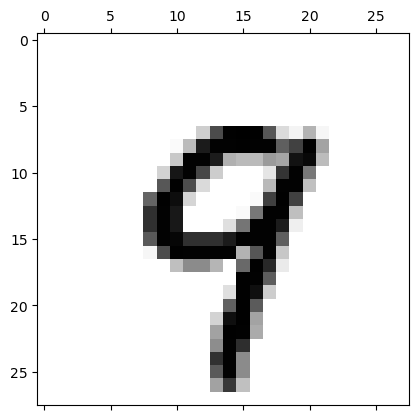

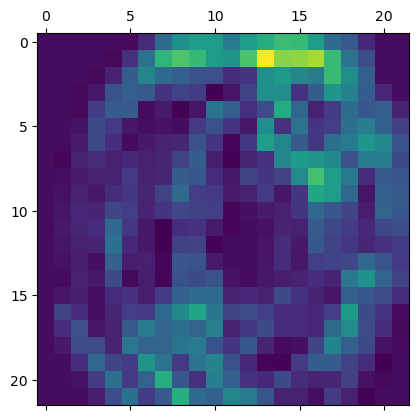

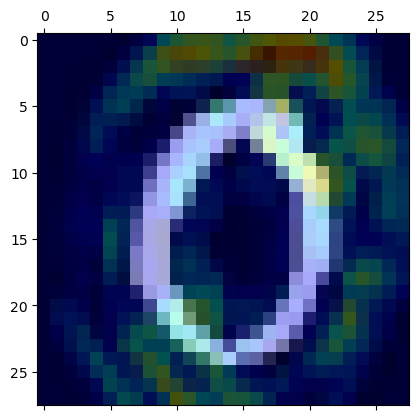

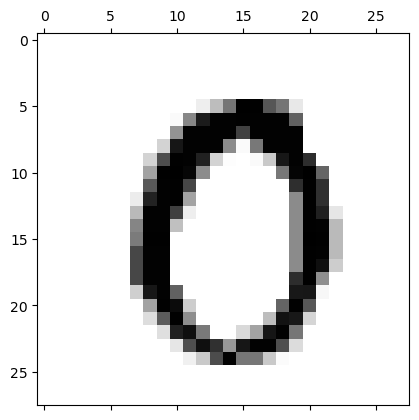

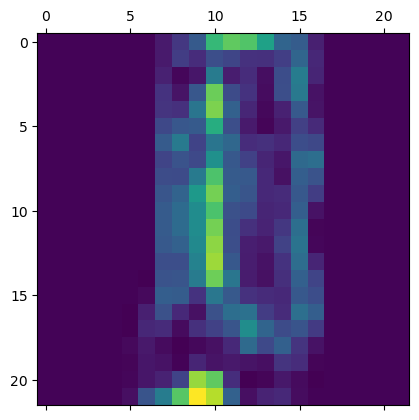

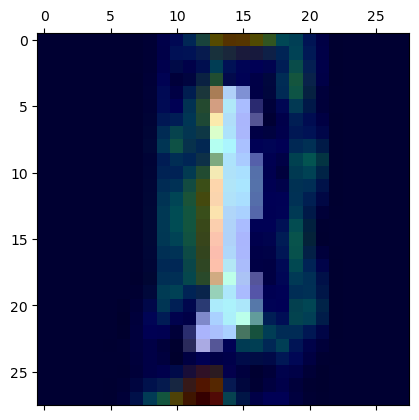

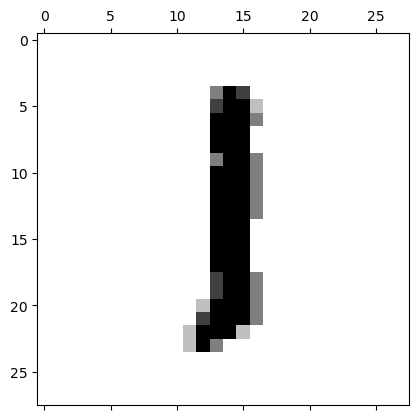

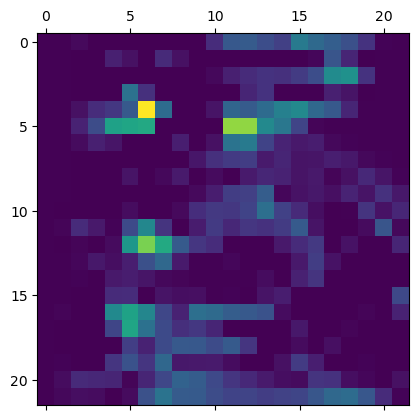

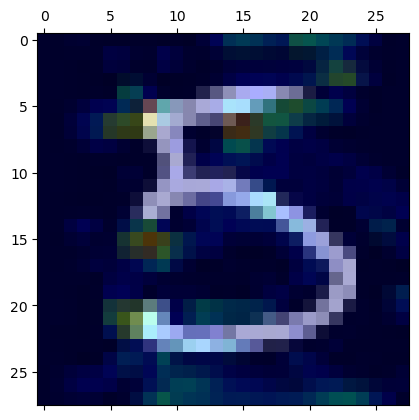

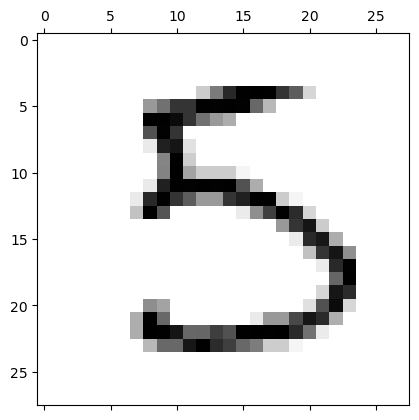

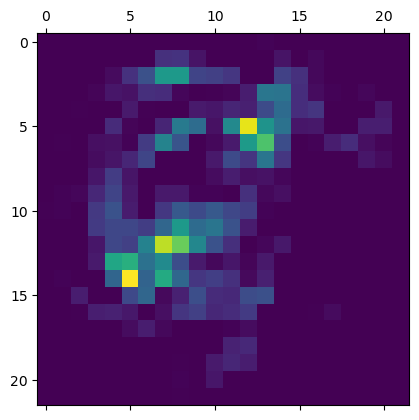

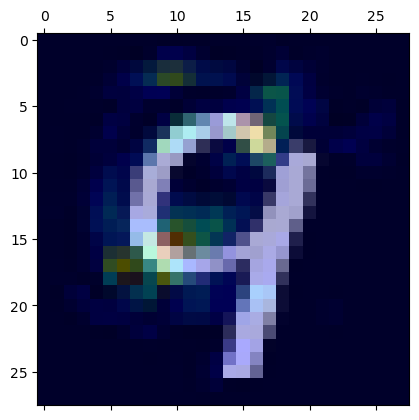

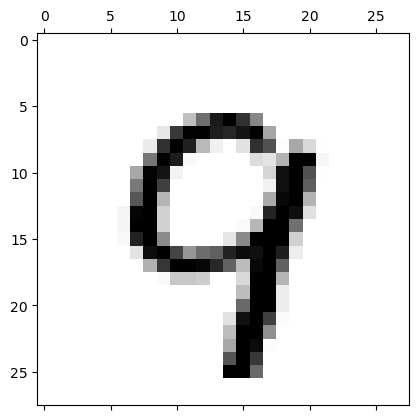

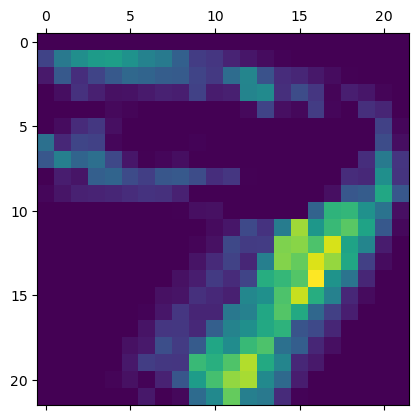

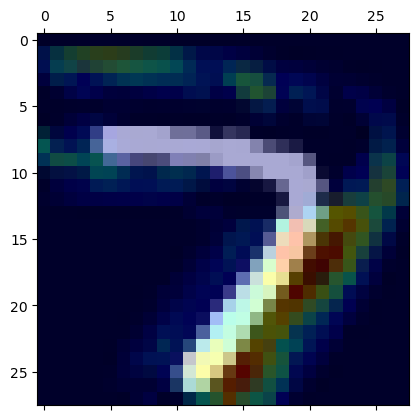

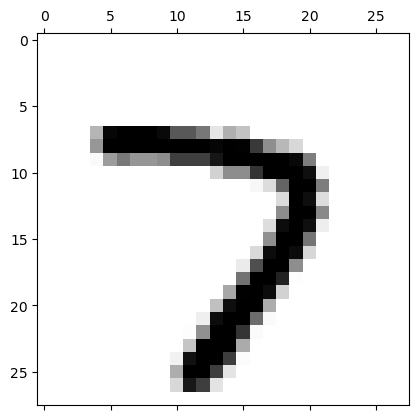

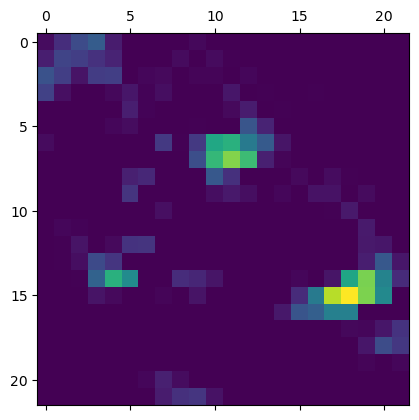

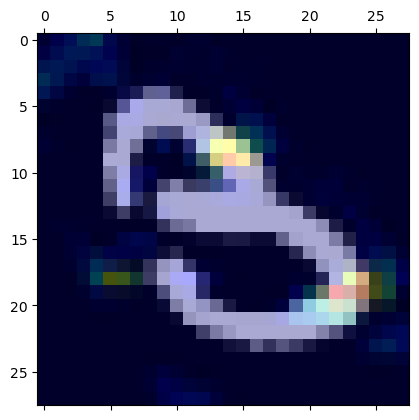

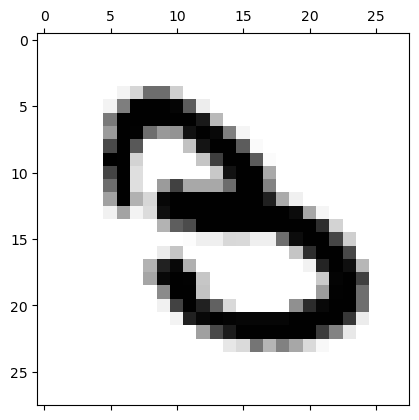

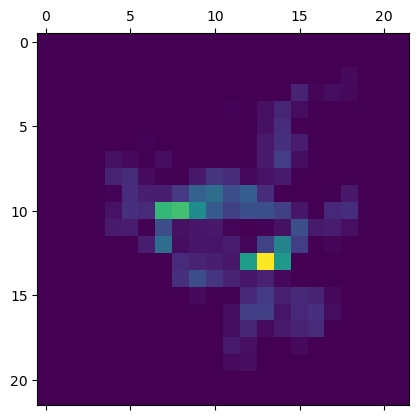

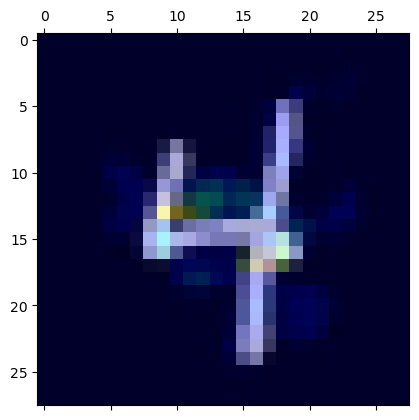

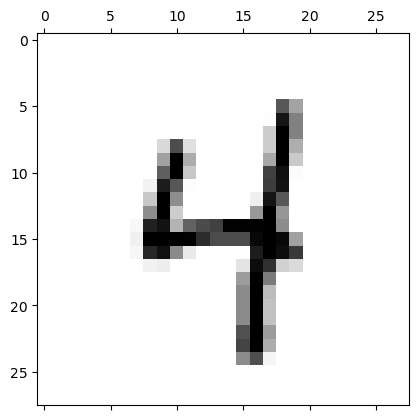

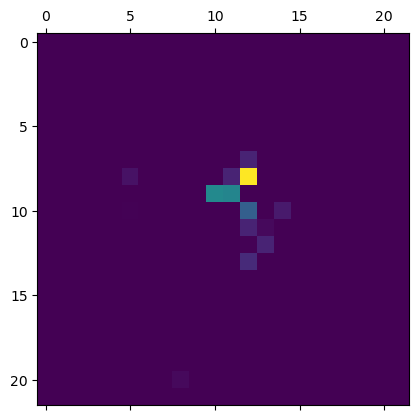

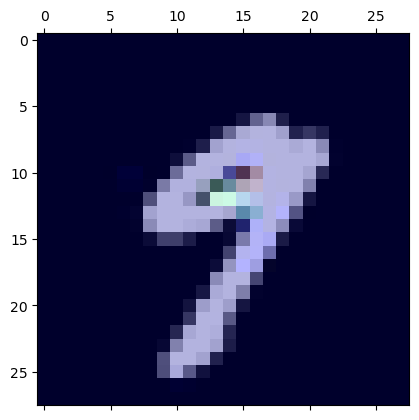

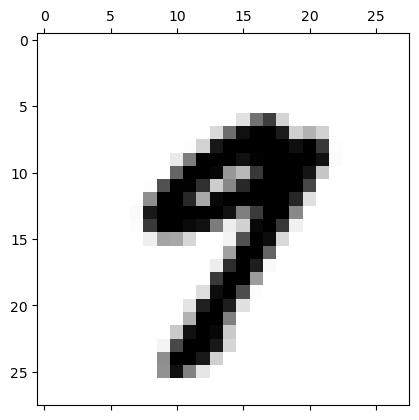

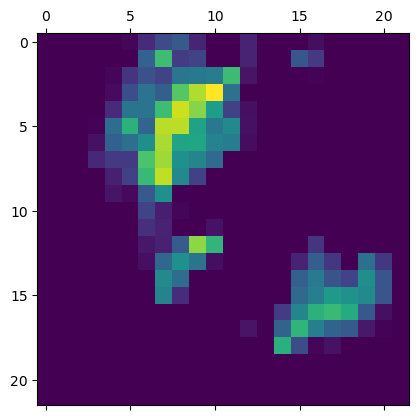

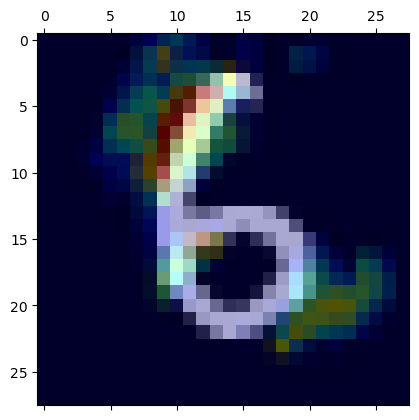

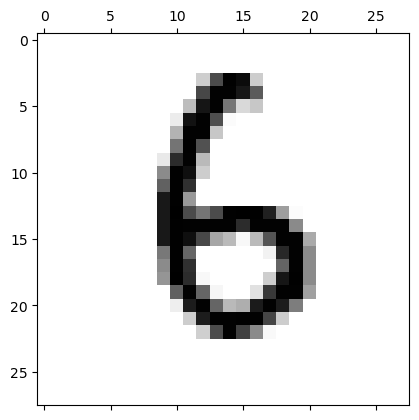

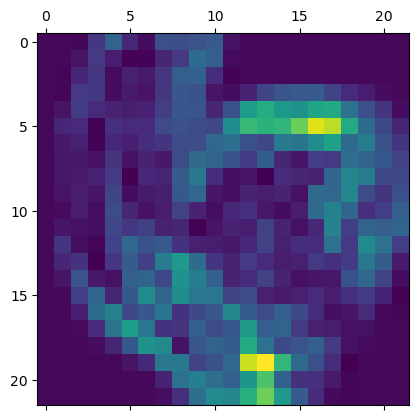

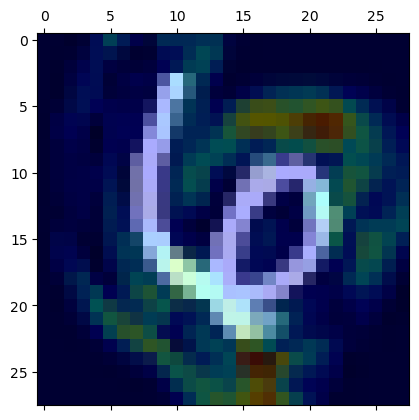

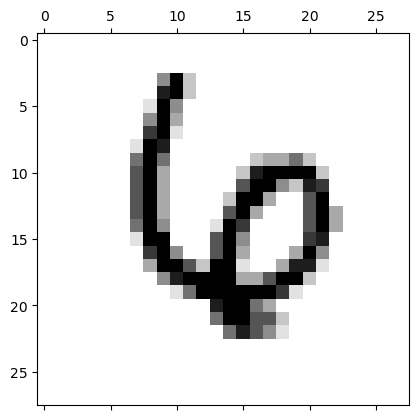

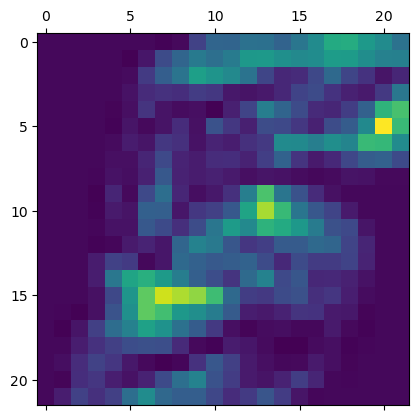

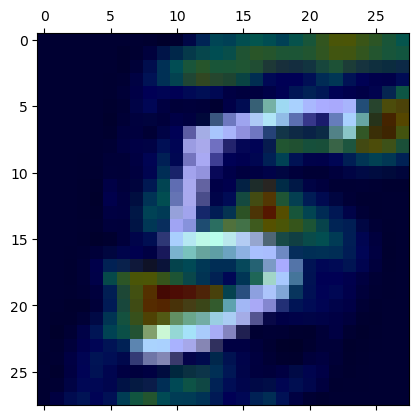

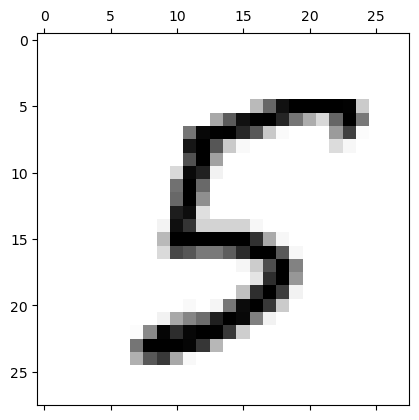

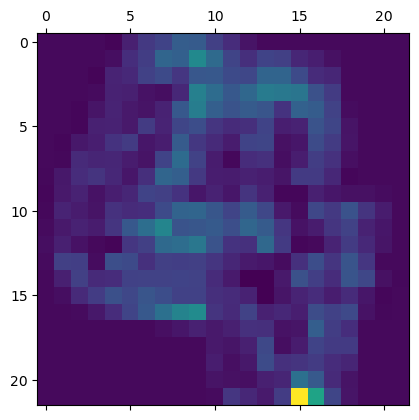

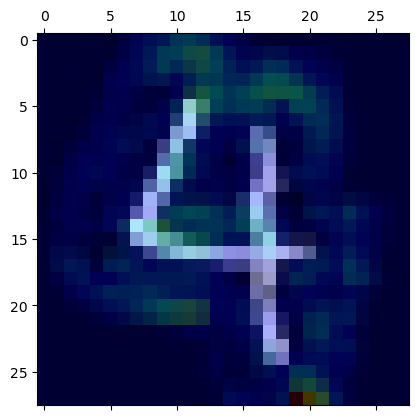

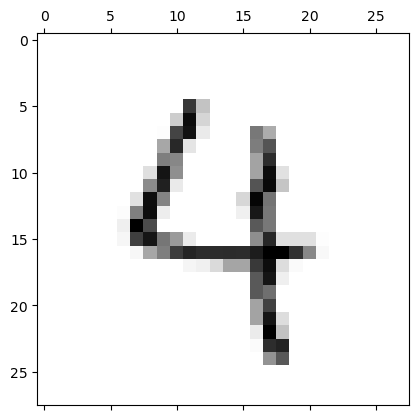

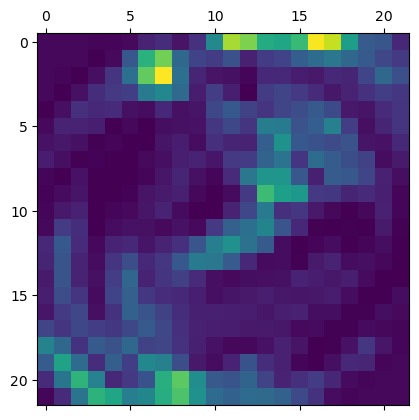

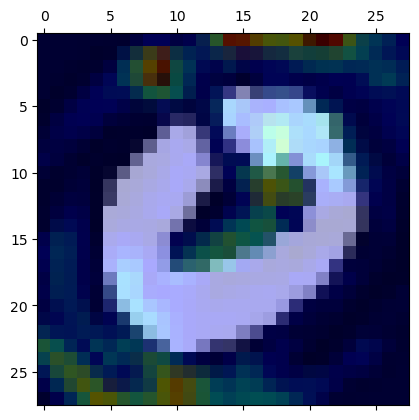

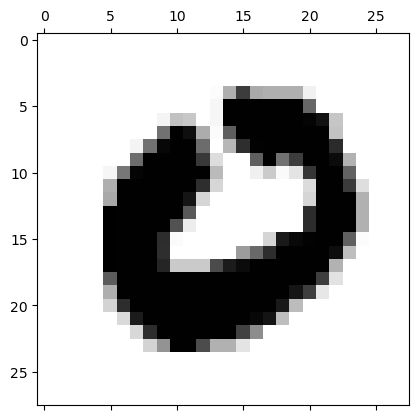

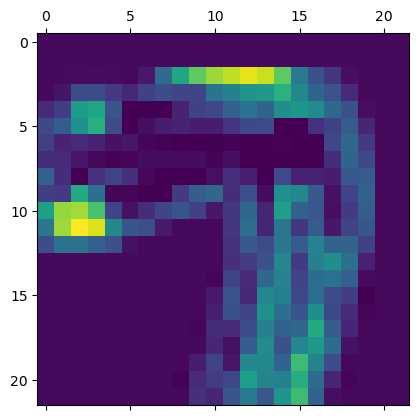

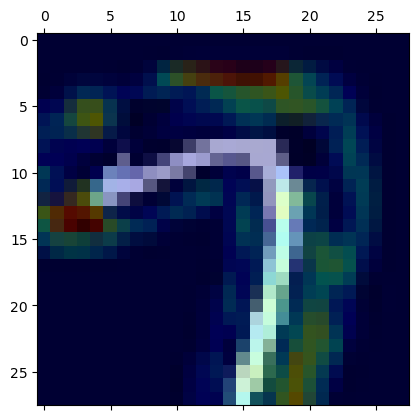

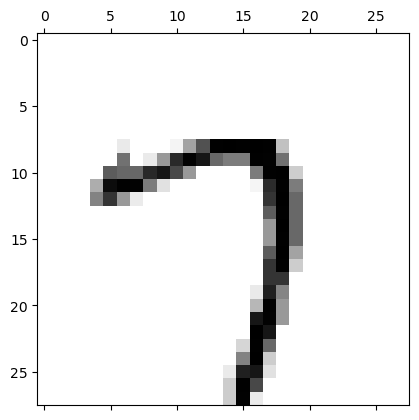

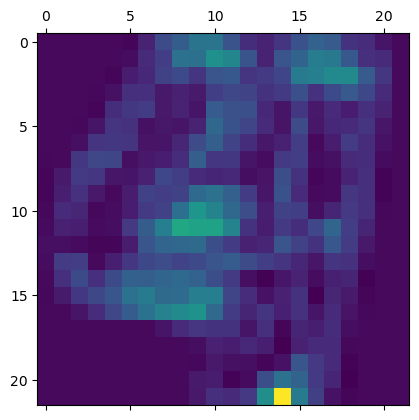

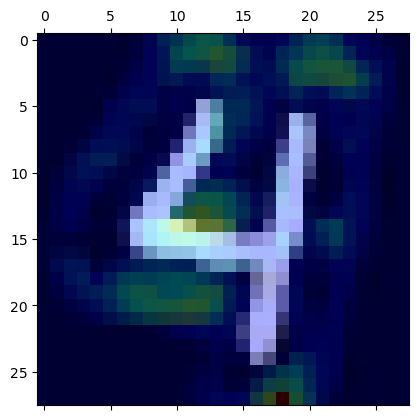

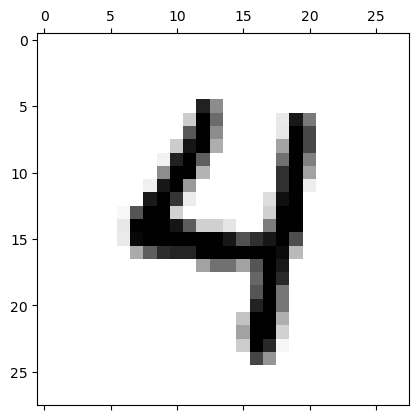

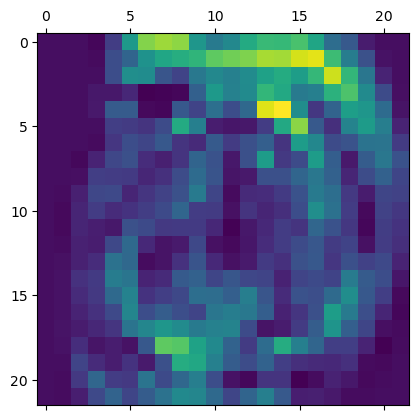

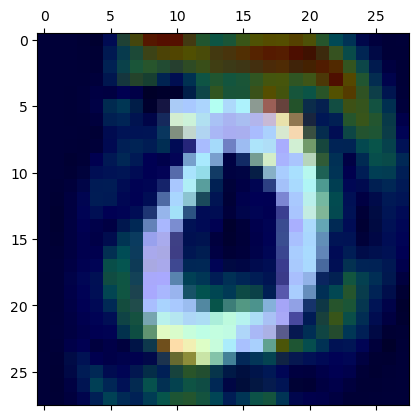

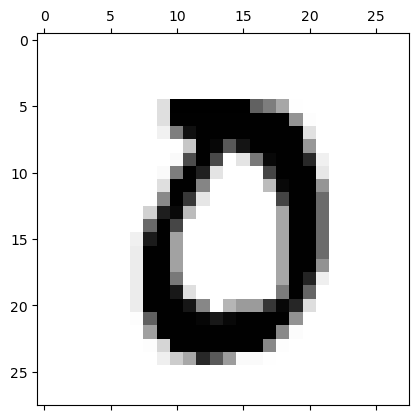

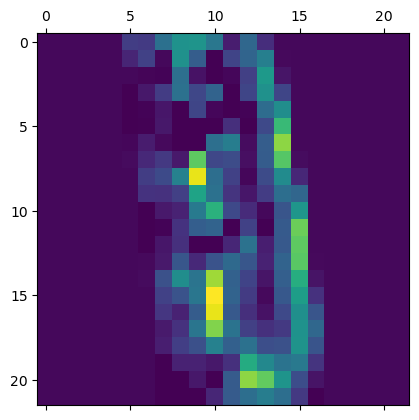

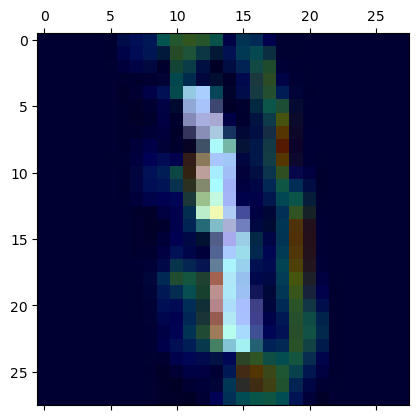

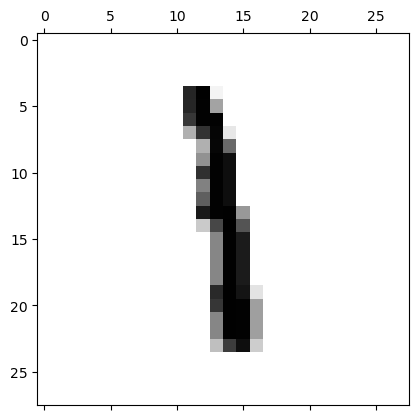

In [180]:
#without maxpooling with second conv
for i in range(10,30):
    heat = heatmap_creator(model, 'last_conv', ['maxpool', 'flatten', 'dropout', 'dense', 'softmax'])
    heatmap = heat.create_visualization(x_test[i])

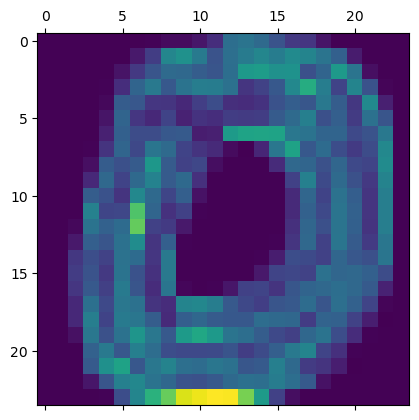

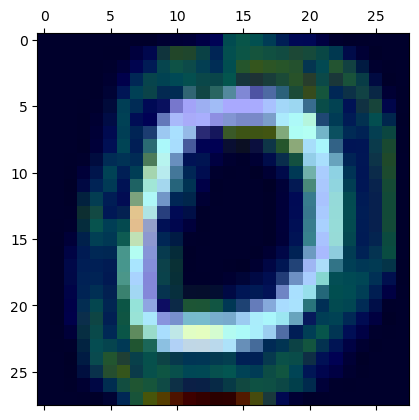

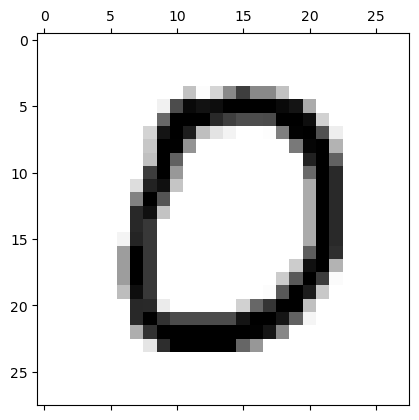

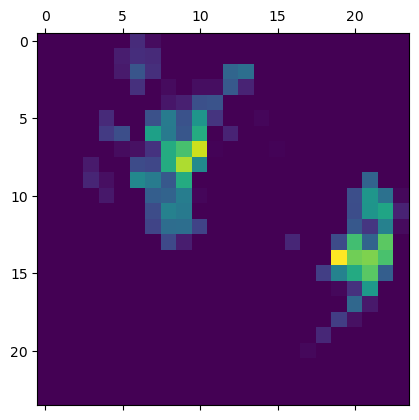

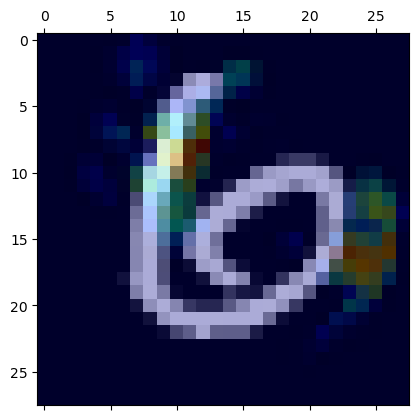

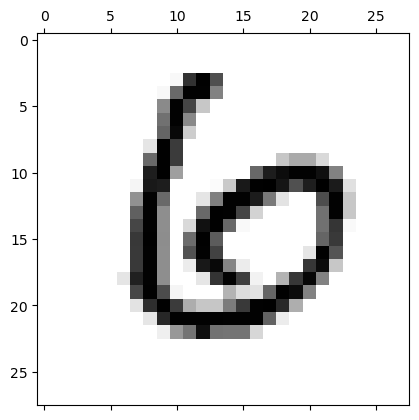

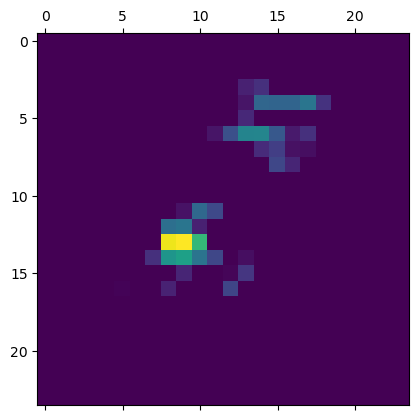

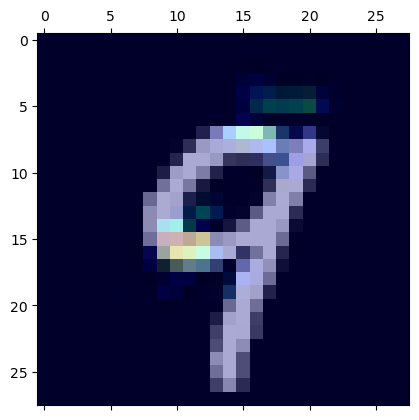

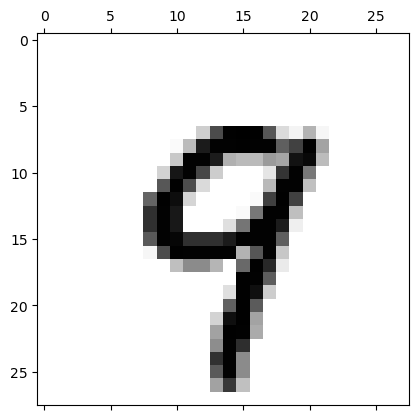

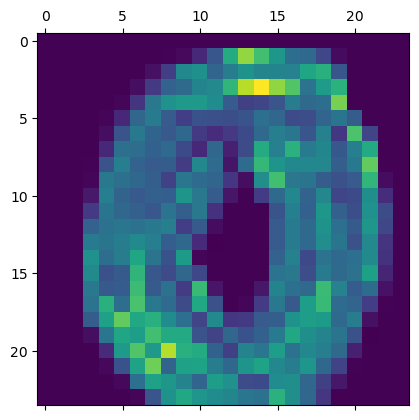

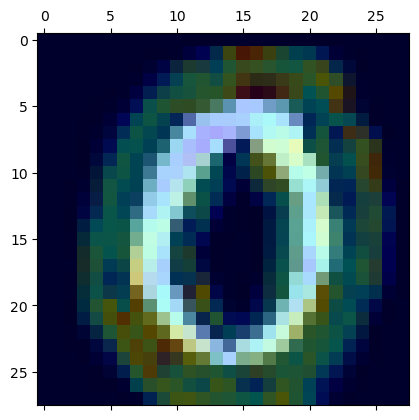

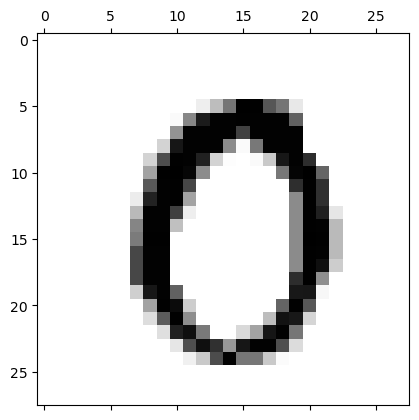

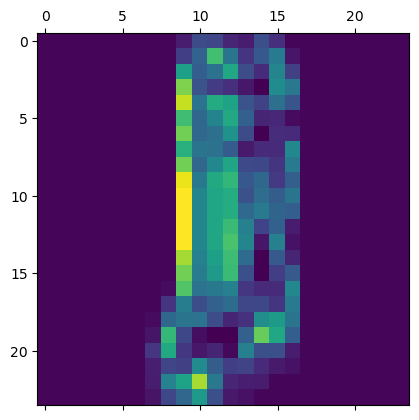

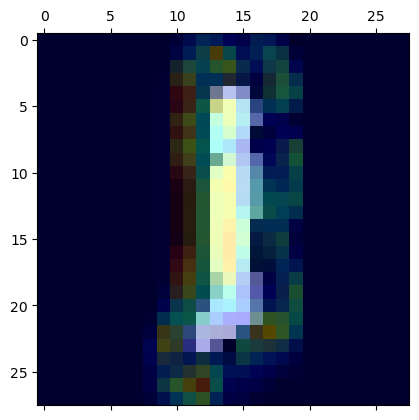

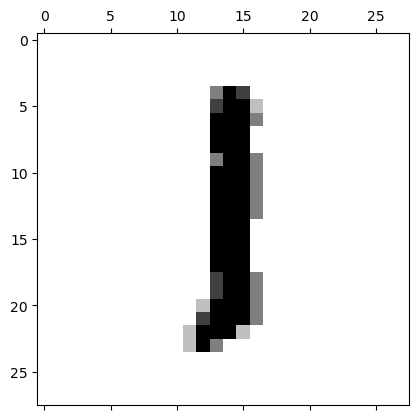

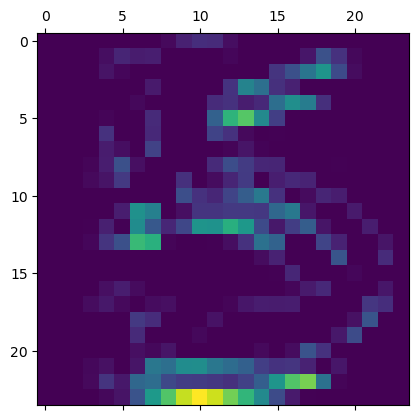

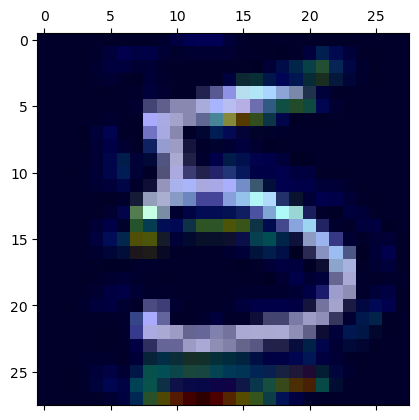

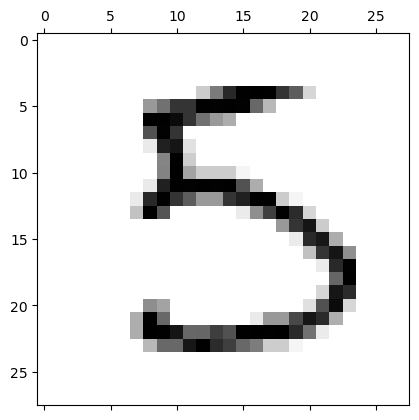

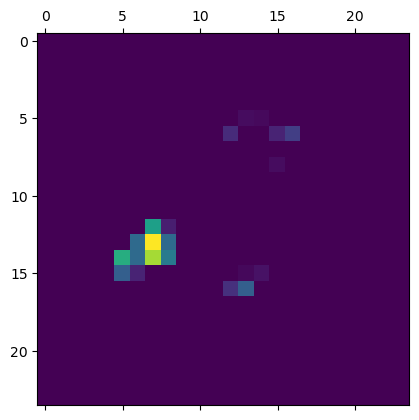

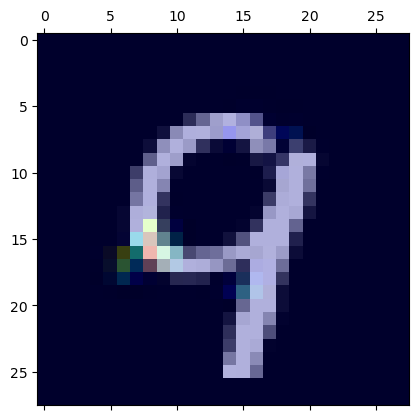

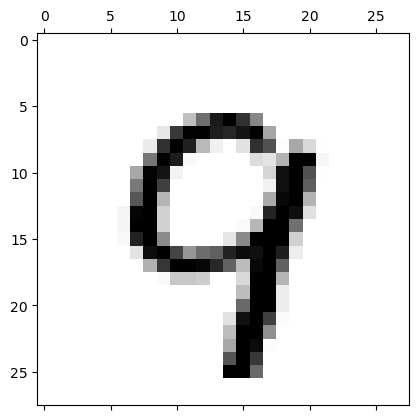

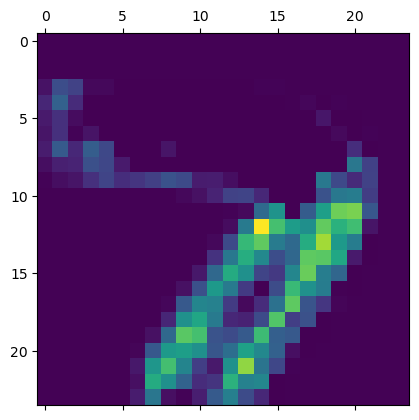

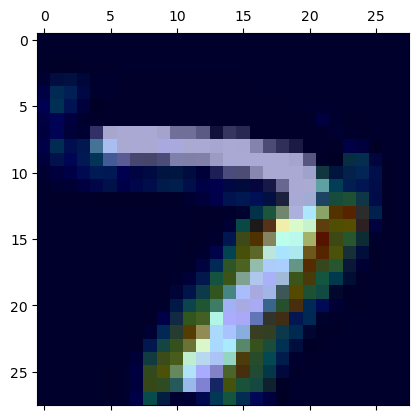

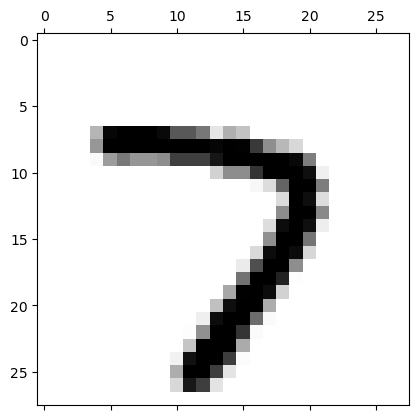

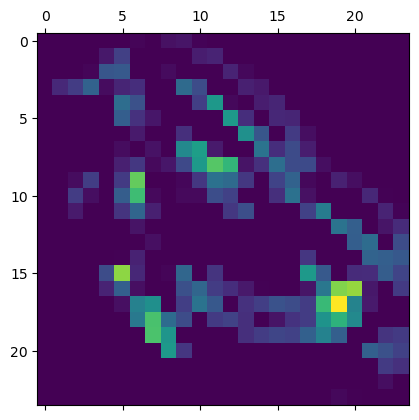

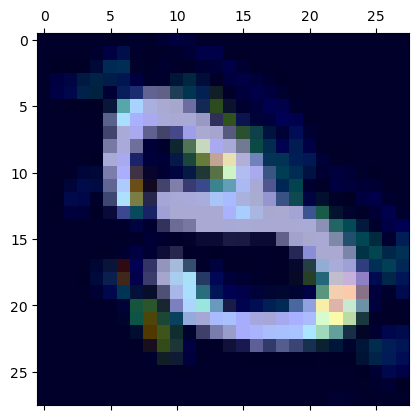

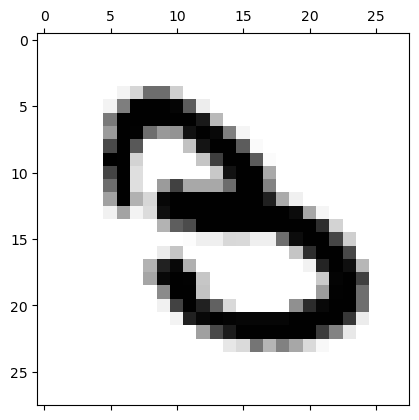

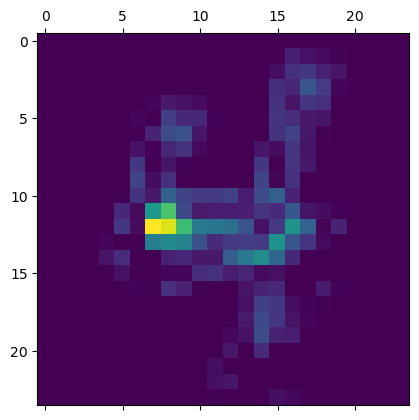

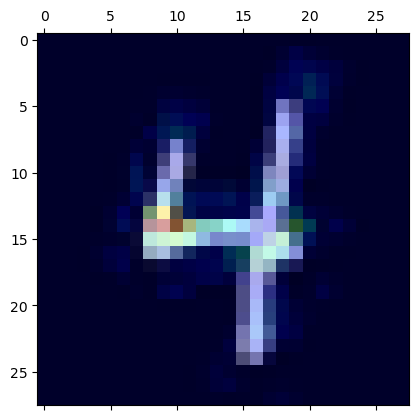

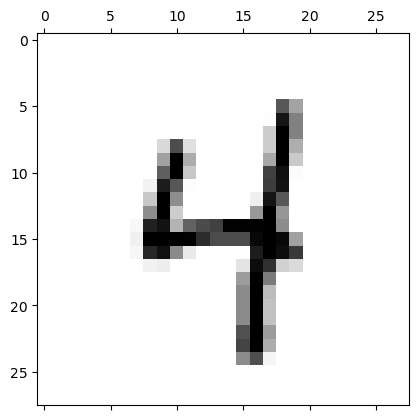

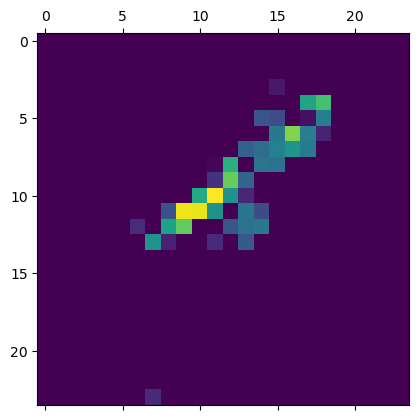

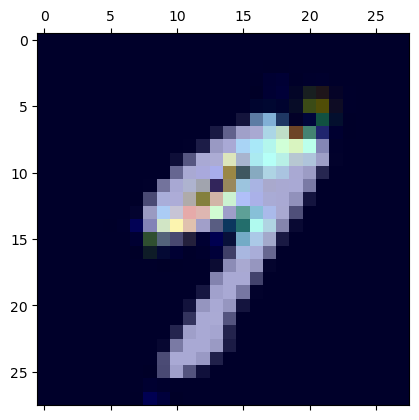

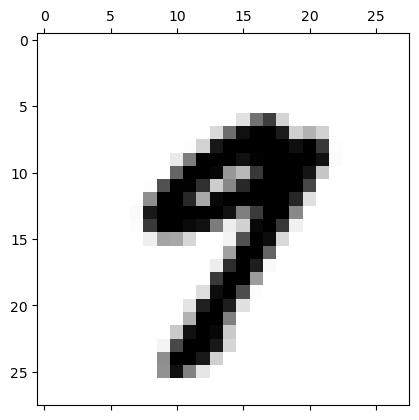

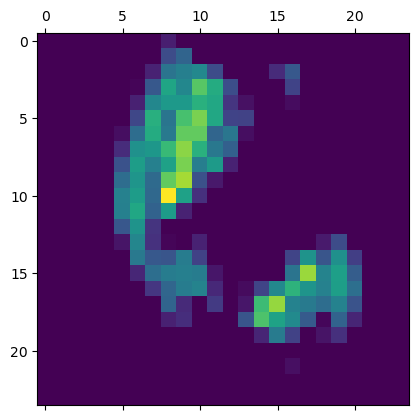

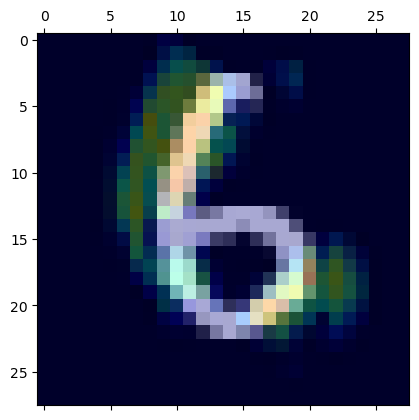

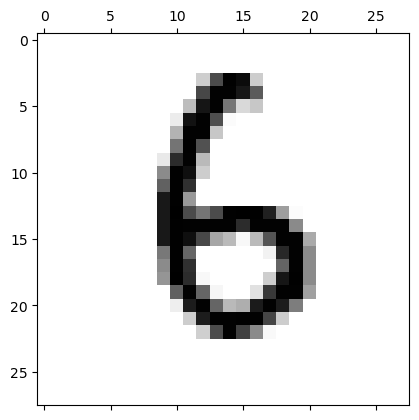

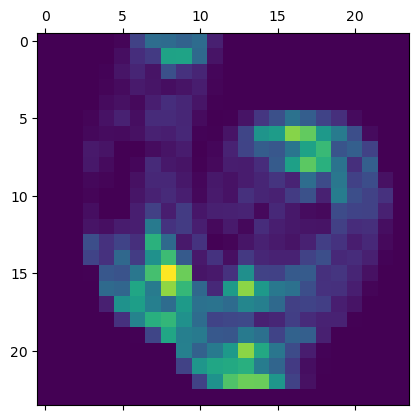

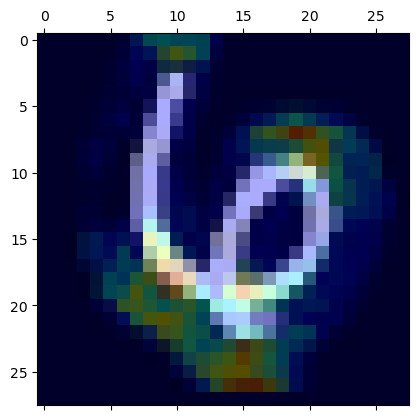

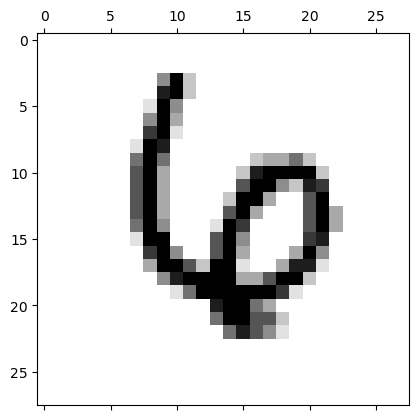

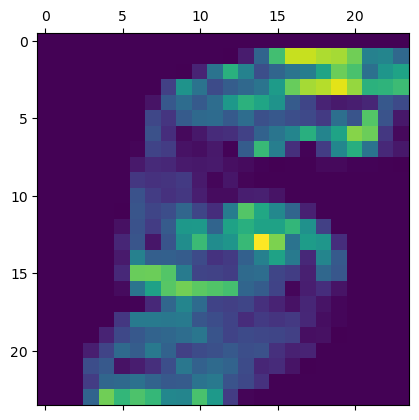

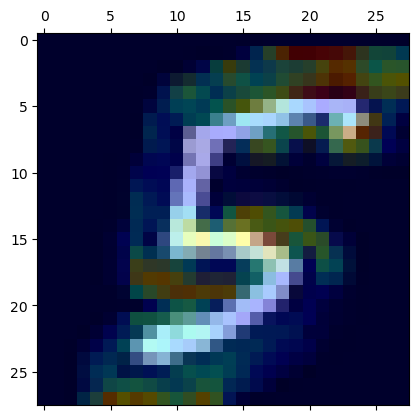

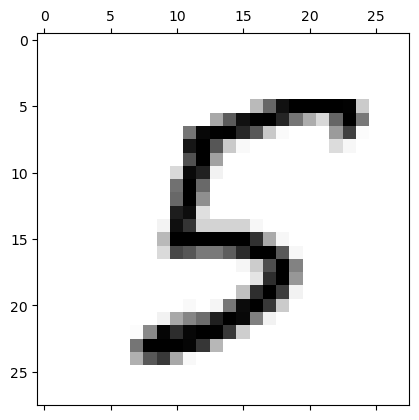

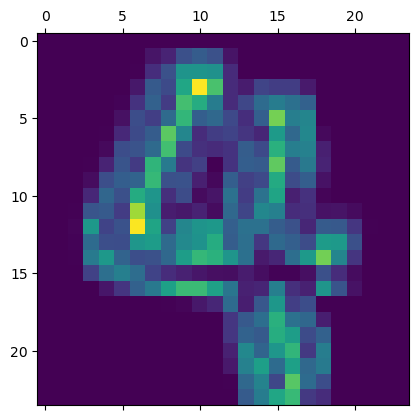

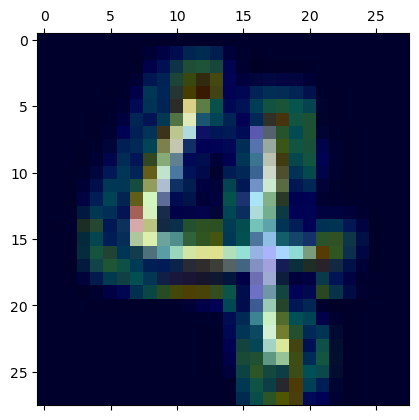

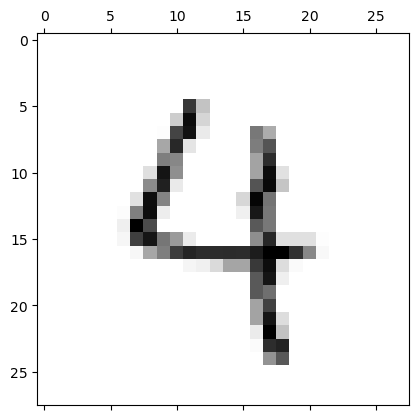

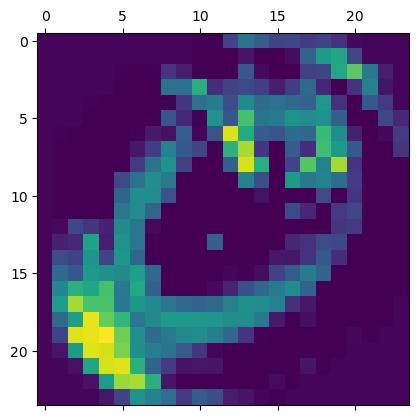

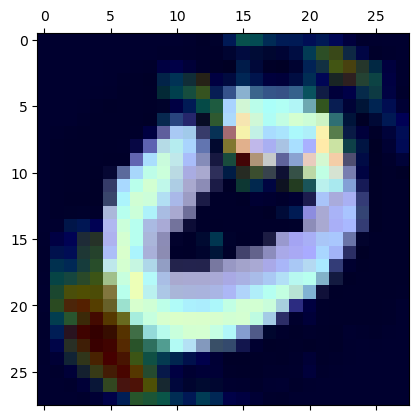

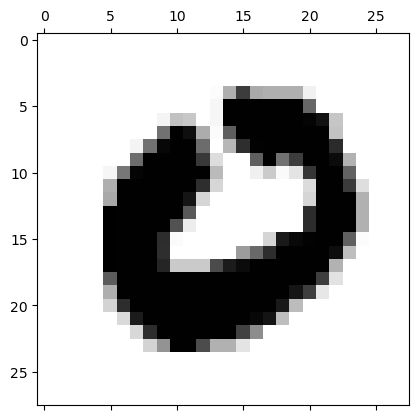

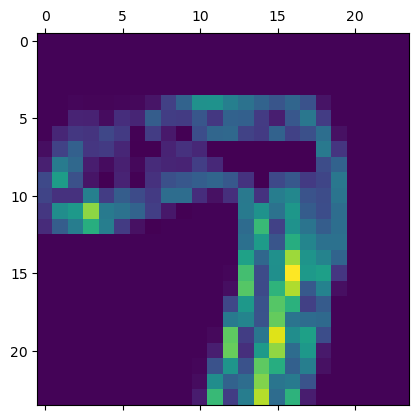

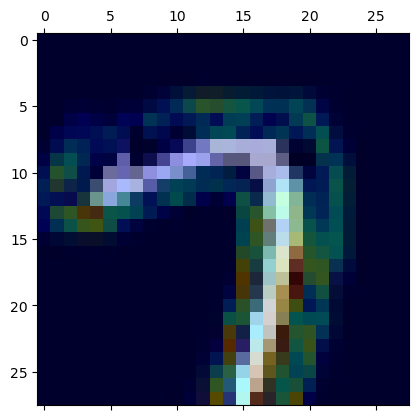

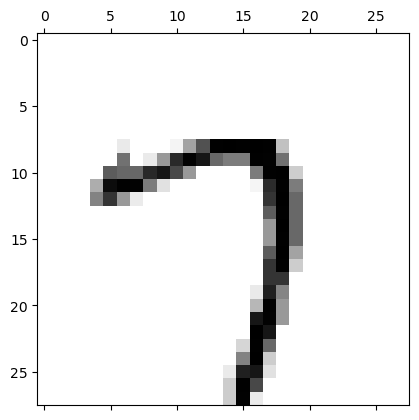

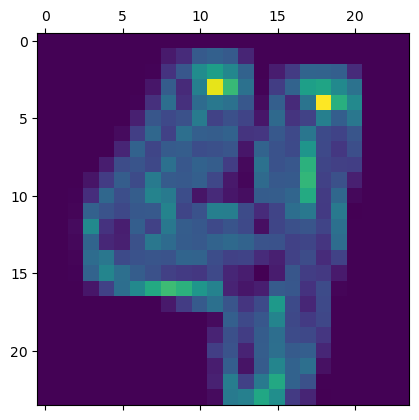

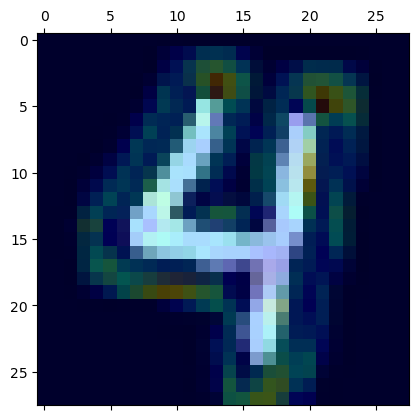

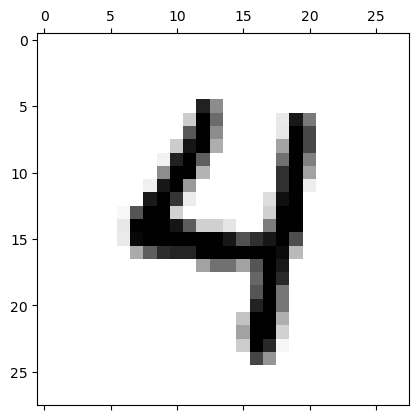

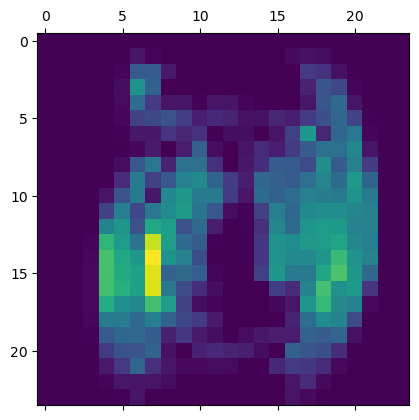

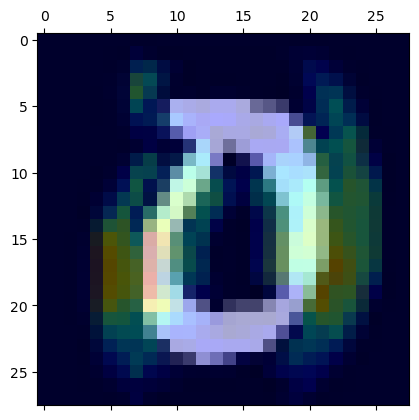

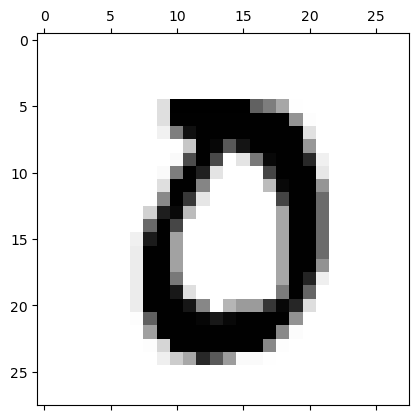

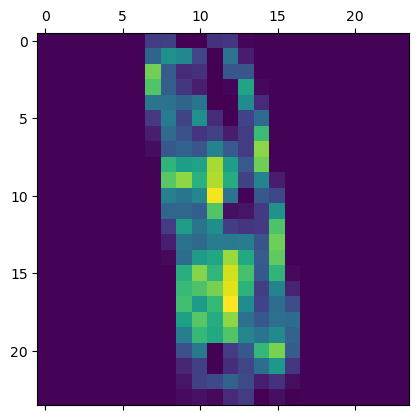

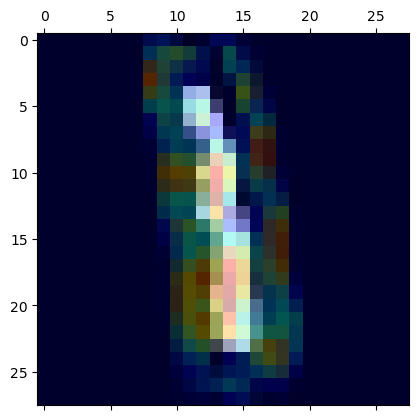

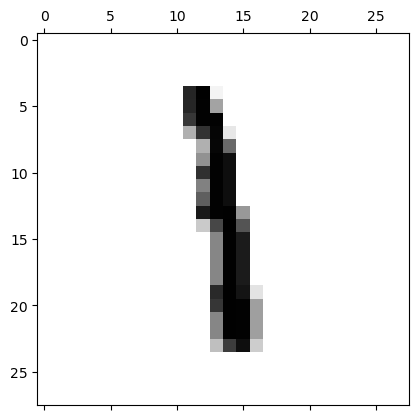

In [183]:
#without 2 maxpooling  but with avg pooling with second conv
for i in range(10,30):
    heat = heatmap_creator(model, 'last_conv', ['maxpool', 'flatten', 'dropout', 'dense', 'softmax'])
    heatmap = heat.create_visualization(x_test[i])

In [ ]:
## Testowanie różnych modeli

## Testowanie różnych modeli

In [185]:
model_1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        # layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Flatten(name = 'flatten'),
        layers.Dropout(0.5, name = 'dropout'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_1 = model_1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14
422/422 [==============================] - 55s 131ms/step - loss: 0.1931 - accuracy: 0.9401 - val_loss: 0.2998 - val_accuracy: 0.9805
Epoch 2/14
422/422 [==============================] - 49s 116ms/step - loss: 0.0710 - accuracy: 0.9782 - val_loss: 0.0468 - val_accuracy: 0.9857
Epoch 3/14
422/422 [==============================] - 50s 117ms/step - loss: 0.0546 - accuracy: 0.9826 - val_loss: 0.0418 - val_accuracy: 0.9877
Epoch 4/14
422/422 [==============================] - 50s 118ms/step - loss: 0.0436 - accuracy: 0.9863 - val_loss: 0.0485 - val_accuracy: 0.9855
Epoch 5/14
422/422 [==============================] - 50s 118ms/step - loss: 0.0359 - accuracy: 0.9882 - val_loss: 0.0433 - val_accuracy: 0.9877
Epoch 6/14
422/422 [==============================] - 50s 119ms/step - loss: 0.0331 - accuracy: 0.9891 - val_loss: 0.0462 - val_accuracy: 0.9875
Epoch 7/14
422/422 [==============================] - 51s 121ms/step - loss: 0.0280 - accuracy: 0.9905 - val_loss: 0.0369 - val_ac

In [186]:
model_2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        # layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Flatten(name = 'flatten'),
        layers.Dropout(0.5, name = 'dropout'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_2 = model_2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14
422/422 [==============================] - 52s 124ms/step - loss: 0.1819 - accuracy: 0.9435 - val_loss: 0.2146 - val_accuracy: 0.9812
Epoch 2/14
422/422 [==============================] - 51s 122ms/step - loss: 0.0674 - accuracy: 0.9794 - val_loss: 0.0488 - val_accuracy: 0.9867
Epoch 3/14
422/422 [==============================] - 52s 122ms/step - loss: 0.0505 - accuracy: 0.9838 - val_loss: 0.0469 - val_accuracy: 0.9853
Epoch 4/14
422/422 [==============================] - 52s 124ms/step - loss: 0.0413 - accuracy: 0.9869 - val_loss: 0.0396 - val_accuracy: 0.9905
Epoch 5/14
422/422 [==============================] - 51s 120ms/step - loss: 0.0375 - accuracy: 0.9883 - val_loss: 0.0386 - val_accuracy: 0.9892
Epoch 6/14
422/422 [==============================] - 51s 120ms/step - loss: 0.0330 - accuracy: 0.9887 - val_loss: 0.0395 - val_accuracy: 0.9897
Epoch 7/14
422/422 [==============================] - 50s 118ms/step - loss: 0.0304 - accuracy: 0.9897 - val_loss: 0.0353 - val_ac

In [188]:
model_3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool1'),
        # layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Flatten(name = 'flatten'),
        layers.Dropout(0.5, name = 'dropout'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_3 = model_3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14
422/422 [==============================] - 16s 38ms/step - loss: 0.3694 - accuracy: 0.8899 - val_loss: 0.0808 - val_accuracy: 0.9792
Epoch 2/14
422/422 [==============================] - 13s 31ms/step - loss: 0.1114 - accuracy: 0.9654 - val_loss: 0.0609 - val_accuracy: 0.9823
Epoch 3/14
422/422 [==============================] - 13s 31ms/step - loss: 0.0871 - accuracy: 0.9733 - val_loss: 0.0477 - val_accuracy: 0.9872
Epoch 4/14
422/422 [==============================] - 14s 33ms/step - loss: 0.0724 - accuracy: 0.9776 - val_loss: 0.0438 - val_accuracy: 0.9870
Epoch 5/14
422/422 [==============================] - 14s 33ms/step - loss: 0.0624 - accuracy: 0.9808 - val_loss: 0.0394 - val_accuracy: 0.9883
Epoch 6/14
422/422 [==============================] - 15s 35ms/step - loss: 0.0556 - accuracy: 0.9828 - val_loss: 0.0381 - val_accuracy: 0.9893
Epoch 7/14
422/422 [==============================] - 18s 42ms/step - loss: 0.0515 - accuracy: 0.9841 - val_loss: 0.0344 - val_accuracy:

In [189]:
model_4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        # layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.BatchNormalization(),
        layers.Flatten(name = 'flatten'),
        layers.Dropout(0.5, name = 'dropout'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_4 = model_4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14
422/422 [==============================] - 80s 189ms/step - loss: 0.2132 - accuracy: 0.9431 - val_loss: 2.3833 - val_accuracy: 0.5085
Epoch 2/14
422/422 [==============================] - 75s 177ms/step - loss: 0.0978 - accuracy: 0.9747 - val_loss: 0.0695 - val_accuracy: 0.9850
Epoch 3/14
422/422 [==============================] - 75s 177ms/step - loss: 0.0758 - accuracy: 0.9792 - val_loss: 0.0659 - val_accuracy: 0.9843
Epoch 4/14
422/422 [==============================] - 75s 179ms/step - loss: 0.0638 - accuracy: 0.9826 - val_loss: 0.0771 - val_accuracy: 0.9827
Epoch 5/14
422/422 [==============================] - 76s 181ms/step - loss: 0.0558 - accuracy: 0.9848 - val_loss: 0.0593 - val_accuracy: 0.9897
Epoch 6/14
422/422 [==============================] - 74s 176ms/step - loss: 0.0481 - accuracy: 0.9866 - val_loss: 0.0574 - val_accuracy: 0.9863
Epoch 7/14
422/422 [==============================] - 75s 177ms/step - loss: 0.0415 - accuracy: 0.9878 - val_loss: 0.0573 - val_ac

In [190]:
model_5 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), 
        layers.BatchNormalization(),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", name = 'last_conv'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Flatten(name = 'flatten'),
        layers.Dropout(0.5, name = 'dropout'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_5 = model_5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14
422/422 [==============================] - 139s 330ms/step - loss: 0.2548 - accuracy: 0.9304 - val_loss: 0.3514 - val_accuracy: 0.8852
Epoch 2/14
422/422 [==============================] - 138s 326ms/step - loss: 0.0915 - accuracy: 0.9745 - val_loss: 0.0620 - val_accuracy: 0.9848
Epoch 3/14
422/422 [==============================] - 138s 328ms/step - loss: 0.0708 - accuracy: 0.9800 - val_loss: 0.0640 - val_accuracy: 0.9843
Epoch 4/14
422/422 [==============================] - 138s 327ms/step - loss: 0.0603 - accuracy: 0.9826 - val_loss: 0.0541 - val_accuracy: 0.9857
Epoch 5/14
422/422 [==============================] - 139s 328ms/step - loss: 0.0552 - accuracy: 0.9847 - val_loss: 0.0518 - val_accuracy: 0.9862
Epoch 6/14
422/422 [==============================] - 134s 318ms/step - loss: 0.0487 - accuracy: 0.9861 - val_loss: 0.0452 - val_accuracy: 0.9897
Epoch 7/14
422/422 [==============================] - 133s 314ms/step - loss: 0.0458 - accuracy: 0.9870 - val_loss: 0.0524 -

In [196]:
model_6 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        # layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Flatten(name = 'flatten'),
        layers.Dropout(0.5, name = 'dropout'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_6 = model_6.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14
422/422 [==============================] - 59s 140ms/step - loss: 0.1737 - accuracy: 0.9464 - val_loss: 0.2572 - val_accuracy: 0.9828
Epoch 2/14
422/422 [==============================] - 61s 143ms/step - loss: 0.0659 - accuracy: 0.9797 - val_loss: 0.0543 - val_accuracy: 0.9860
Epoch 3/14
422/422 [==============================] - 63s 150ms/step - loss: 0.0506 - accuracy: 0.9843 - val_loss: 0.0405 - val_accuracy: 0.9887
Epoch 4/14
422/422 [==============================] - 57s 134ms/step - loss: 0.0428 - accuracy: 0.9863 - val_loss: 0.0385 - val_accuracy: 0.9895
Epoch 5/14
422/422 [==============================] - 58s 138ms/step - loss: 0.0373 - accuracy: 0.9886 - val_loss: 0.0415 - val_accuracy: 0.9888
Epoch 6/14
422/422 [==============================] - 59s 139ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0388 - val_accuracy: 0.9895
Epoch 7/14
422/422 [==============================] - 65s 153ms/step - loss: 0.0276 - accuracy: 0.9905 - val_loss: 0.0420 - val_ac

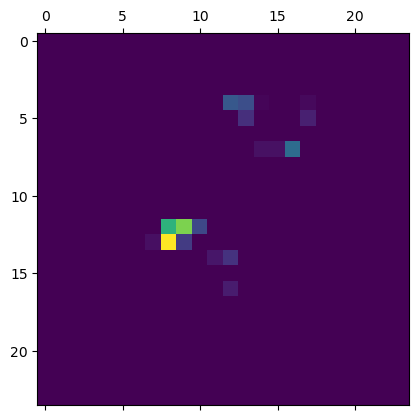

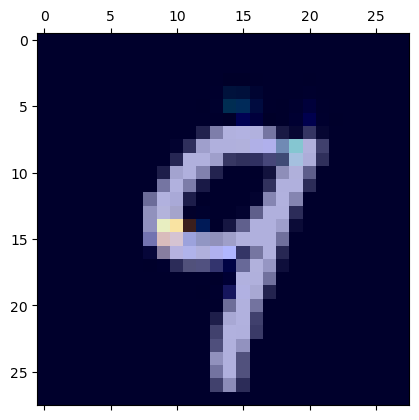

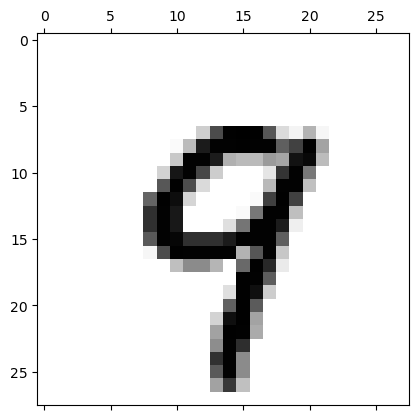

In [198]:
try:
    heat = heatmap_creator(model_6, 'last_conv', ['maxpool', 'flatten', 'dropout', 'dense', 'softmax'])
    heatmap = heat.create_visualization(x_test[12])
except:
    print('sorry')

In [199]:
model_7 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        # layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_7.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_7 = model_7.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14


ValueError: in user code:

    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 10) and (None, 12, 12, 10) are incompatible


In [ ]:
try:
    heat = heatmap_creator(model_7, 'last_conv', ['maxpool',   'dense', 'softmax'])
    heatmap = heat.create_visualization(x_test[12])
except:
    print('sorry')

In [202]:
model_8 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        # layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Flatten(name = 'flatten'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_8.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_8 = model_8.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14
422/422 [==============================] - 49s 117ms/step - loss: 0.1488 - accuracy: 0.9547 - val_loss: 0.2262 - val_accuracy: 0.9823
Epoch 2/14
422/422 [==============================] - 48s 114ms/step - loss: 0.0515 - accuracy: 0.9843 - val_loss: 0.0508 - val_accuracy: 0.9850
Epoch 3/14
422/422 [==============================] - 54s 127ms/step - loss: 0.0399 - accuracy: 0.9871 - val_loss: 0.0426 - val_accuracy: 0.9885
Epoch 4/14
412/422 [============================>.] - ETA: 1s - loss: 0.0276 - accuracy: 0.9915

KeyboardInterrupt: 

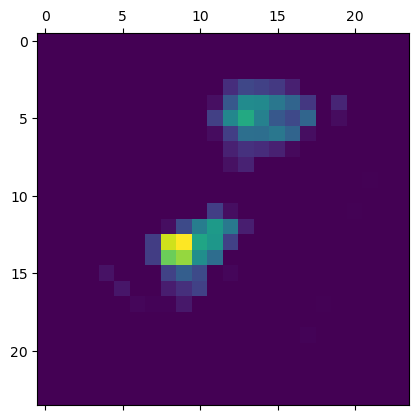

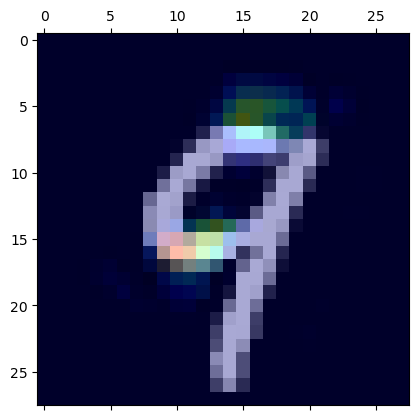

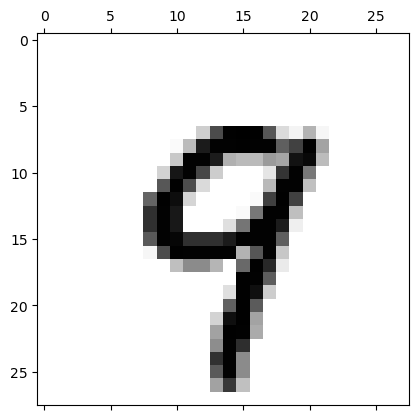

In [203]:
try:
    heat = heatmap_creator(model_8, 'last_conv', ['maxpool', 'flatten',  'dense', 'softmax'])
    heatmap = heat.create_visualization(x_test[12])
except:
    print('sorry')

In [204]:
model_9 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name = 'last_conv'), 
        # layers.MaxPooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.AveragePooling2D(pool_size=(2, 2), name = 'maxpool'),
        layers.Dense(num_classes, name = 'dense'),
        layers.Activation('softmax', name = 'softmax')
    ],
    name='model'
)

batch_size = 128
epochs = 14

model_9.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_9 = model_9.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/14


ValueError: in user code:

    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    c:\Users\WojciechOlejko\miniconda3\envs\lab2\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 10) and (None, 11, 11, 10) are incompatible


In [ ]:
try:
    heat = heatmap_creator(model_9, 'last_conv', ['maxpool', 'dense', 'softmax'])
    heatmap = heat.create_visualization(x_test[12])
except:
    print('sorry')